# Случайные процессы. Прикладной поток.
## Практическое задание 2

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 2"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `2.N.ipynb` и `2.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.
* Дедлайн и система оценивания будут объявлены позже.

<h1><font color = "red">Ниже идёт Практическое задание 1. Практическое задание 2 является его продолжением и начинается с аналогичного, заголовка. Просто пролистайте вниз до такой надписи (39 страница PDF).</font></h1>

<IMG SRC="https://www.wikitree.com/images/wikitree-logo.png">


В Британской империи в Викторианскую эпоху (1837—1901) было обращено внимание на вымирание аристократических фамилий. В связи с этим в своей статье в The Educational Times в 1873 году Гальтон поставил вопрос о вероятности вымирания фамилии. Решение этого вопроса нашел Ватсон и вместе в 1874 году они написали статью "On the probability of the extinction of families".
На сайте <a href="http://wikitree.com">wikitree.com</a> в свободно распространяемом формате собрано большое количество данных о родословных различных людей. В коллекции есть как люди, жившие во времена поздней античности, так и наши современники. На основе некоторой части этих данных вам предстоит провести исследование о вымирании фамилий.

Вам предоставляются несколько файлов, в которых содержатся данные о некоторых родословных. Вам предстоит проводить исследование на нескольких из этих файлов (каких именно, см. в таблице). Формат файлов следующий:

`generation \t name \t gender \t birthday \t deathdate \t parents \t siblings \t spouses \t children`

Эти данные означают номер поколения, фамилию, пол, дату рождения, дату смерти, родителей, братьев и сестер, супруг, детей соответственно. Если какая-то характеристика неизвестна (кроме номера поколения и фамилии), вместо нее ставится пустая подстрока. Если каких-то характеристик несколько, то они разделены через ";". Все люди представлены некоторым идентификатором `<id>`, который соответствует адресу `http://www.wikitree.com/wiki/<id>`. Например, идентификатор `Romanov-29` соответствует адресу <a href="http://www.wikitree.com/wiki/Romanov-29">`http://www.wikitree.com/wiki/Romanov-29`</a>. В файле родословные отделяются друг от друга пустой строкой.

Для облегчения вашей работы мы предоставляем вам код, который считывает данные из этого файла и преобразует их в список ветвящихся процессов. Каждый ветвящийся процесс содержит список списков, в каждом из которых содержатся все люди из соответствующего поколения. Обратите внимание, что одни и те же родословные могут попасть в разные файлы. В таком случае их можно считать разными, но при желании вы можете удалить копии.

В предоставленных данных в каждой родословной для каждого мужчины на следующем поколении содержатся все его дети, которые были указаны на сайте. Для женщин дети в данной родословной не указаны. Это связано с тем, что женщины обычно меняют свою фамилию, когда выходят замуж, тем самым, они переходят в другую ветку. С точки зрения ветвящихся процессов, нужно иметь в виду, что если у мужчины родилось 3 мальчика и 4 девочки, то у него 3 потомка как продолжателя фамилии.

Ваша задача --- исследовать процесс вымирания фамилий на основе предложенных данных. В данном задании вам предстоит сделать оценку закона размножения, а в следующем задании --- провести остальной анализ.

In [1]:
import numpy as np
import scipy.stats as sps
from collections import Counter  # это может пригодиться
from BranchingProcess import Person, BranchingProcess, read_from_files

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 16})
%matplotlib inline

## часто исользуемый код вынесен в начало

# линейная регрессия из прошлого семестра
# (а вдруг, LinearRegression из sklearn не сходится?)
class LinearRegression:
    def __init__(self):
        super()
        
    def fit(self, X, Y, alpha=0.95):
        ''' Обучение модели. Предполагается модель Y = X * theta + epsilon, 
            где X --- регрессор, Y --- отклик,
            а epsilon имеет нормальное распределение с параметрами N(0, sigma^2 * I_n).
            alpha --- уровень доверия для доверительного интервала.
        '''
        
        self.n, self.k = X.shape

        self.theta = np.linalg.inv(X.T @ X) @ (X.T) @ Y
            # МНК-оценка = (Z.T * Z)^-1 * Z.T * Y

        vector = Y - X @ self.theta
        self.sigma_sq = 1. / (self.n - self.k) * (vector @ vector.T)
            # несмещенная оценка для sigma^2 = 1 / (n - k) * || Y - X * self.theta || ^2 

        a = np.linalg.inv(X.T @ X)
        u_upper = sps.t.ppf((1. + alpha) / 2., self.n - self.k)
        u_lower = sps.t.ppf((1. - alpha) / 2., self.n - self.k)
        ci = [
            [self.theta[i] - np.sqrt(abs(a[i][i] * self.sigma_sq)) * u_upper,
             self.theta[i] - np.sqrt(abs(a[i][i] * self.sigma_sq)) * u_lower]
            for i in range(self.k)
        ]
        self.conf_int = np.array(ci)
        
        return self
    
    def summary(self):
        print('Linear regression on %d features and %d examples' % (self.k, self.n))
        print('Sigma: %.6f' % self.sigma_sq)
        print('\t\tLower\t\tEstimation\tUpper')
        for j in range(self.k):
            print('theta_%d:\t%.6f\t%.6f\t%.6f' % (j, self.conf_int[j, 0], 
                                                   self.theta[j], self.conf_int[j, 1]))
        
    def predict(self, X):
        ''' Возвращает предсказание отклика на новых объектах X. '''
        
        Y_pred = X @ self.theta
        return Y_pred
    
# сделаем удобоваримый интерфейс
def make_linear_regression_like_polyfit(X, Y):
    LR = LinearRegression()
    LR_X = np.array([np.ones(len(X)), X]).T
    LR.fit(LR_X, np.array(Y).reshape(len(Y), 1))
    return LR

# сделаем удобоваримый интерфейс
def predict_linear_regression_like_polyfit(LR, X):
    return LR.predict(np.array([np.ones(len(X)), X]).T)


# ниже - код с первого семинара
from sklearn.neighbors import KernelDensity as KDE

def norm_plot(x, bins=10, bandwidth=1):
    plt.figure(figsize=(10, 6))
    plt.hist(x, label="hist", bins=bins, normed=True, color='turquoise')

    xmin, xmax = plt.xlim()
    x_axis = np.linspace(xmin, xmax, 300)

    n_params = sps.norm.fit(x)
    plt.plot(x_axis,
             sps.norm.pdf(x_axis, loc=n_params[0], scale=n_params[1]),
             label="norm_pdf")

    kernel_density = KDE(bandwidth=bandwidth).fit(x[:, np.newaxis])
    plt.plot(x_axis, np.exp(kernel_density.score_samples(x_axis[:, np.newaxis])), label='kde')

    plt.legend()
    plt.show()
    
def check_norm(x, bins=10, alpha=0.05):    
    print("Гипотеза: распределение нормальное.\n")
    
    shtest = sps.shapiro(x)
    print("Статистика критерия Шапиро-Уилка:", round(shtest[0], 5))
    print("p-value: ", round(shtest[1], 5))
    if shtest[1] < alpha:
        print("Гипотеза отвергается.\n")
    else:
        print("Гипотеза не отвергается.\n")

    n_params = sps.norm.fit(x)  # ОМП для нормального распределения
    norm = sps.norm(loc=n_params[0], scale=n_params[1])
    
    kstest = sps.kstest(x, 'norm', args=n_params)
    print("Статистика критерия Колмогорова:", round(kstest.statistic, 5))
    print("p-value: ", round(kstest.pvalue, 5))
    if kstest.pvalue < alpha:
        print("Гипотеза отвергается.\n")
    else:
        print("Гипотеза не отвергается.\n")
    
    # Вспомогательная функция, подсчитывающая число элементов выборки,
    # лежащих в подмножествах разбиения.
    def count_data(x, delim):
        res = []
        res.append((x < delim[0]).sum())
        for i in range(1, len(delim)):
            res.append(((delim[i-1] <= x) & (x < delim[i])).sum())
        res.append((delim[-1] <= x).sum())
        return res
    
    # Критерий хи-квадрат.
    if len(x) < 50:
        return
    
    if 5 > float(len(x)) / bins:
        bins = int(len(x) / 5)
    
    # Разбиение на интервалы, равные по вероятностной мере.
    f_exp = np.ones(bins, dtype=np.float64) / bins
    delim = list(map(lambda y: norm.ppf(y), f_exp.cumsum()))
    delim = delim[:-1]
    ctest = sps.chisquare(count_data(x, delim), f_exp=f_exp * len(x))
    print ("Статистика критерия хи-квадрат при разбиении на интервалы, "\
           "равные по вероятностной мере:",
           round(ctest.statistic, 5))
    print ("p-value: ", round(ctest.pvalue, 5))
    if ctest.pvalue < alpha:
        print ("Гипотеза отвергается.\n")
    else:
        print ("Гипотеза не отвергается.\n")

## 1. Описательный анализ

Большая часть кода, необходимая для проведения данного анализа, является технической и основывается на работе с пакетом `BranchingProcess`. Поэтому данный код полностью вам выдается, вам нужно только выполнить его, подставить имена файлов. Кроме того, код анализа позволит вам лучше понять структуру данных.

Считайте данные с помощью предложенного кода. Посчитайте количество родословных.

In [2]:
with open("Варианты.txt", "r") as f:
    for s in f.readlines():
        if ("Шевкунов" in s):
            print(s)

594 Шевкунов Кирилл Сергеевич АД	-=-	P O N I C R T J S E



In [3]:
first_letters = "P O N I C R T J S E"
fn_prefix = "./data/"
fn_postfix = ".txt"
file_names = []
for c in first_letters:
    if c != " ":
        file_names.append(fn_prefix + c + fn_postfix)

for v in file_names:
    print(v)

./data/P.txt
./data/O.txt
./data/N.txt
./data/I.txt
./data/C.txt
./data/R.txt
./data/T.txt
./data/J.txt
./data/S.txt
./data/E.txt


In [4]:
processes = read_from_files(file_names)
print(len(processes))

55337


В имеющихся данных очень много людей, про которых известно лишь то, что они когда-то существовали. Обычно их фамилия неизвестна (вместо фамилии у них может стоять, к примеру, `B-290`), а у некоторых из них неизвестен даже пол, не говоря уже о родителях и детях. Такие данные стоит удалить.

Удалите все процессы, состоящие только из одного поколения (в котором, естественно, будет только один человек).
Сколько осталось процессов?

In [5]:
for i in range(len(processes))[::-1]:
    if len(processes[i].generations) < 2:
        del processes[i]

print(len(processes))

15841


Для лучшего понимания задачи и предложенных данных посчитайте следующие характеристики: минимальное, максимальное и среднее число поколений в роду, год рождения самого старого и самого молодого человека, среднюю продолжительность жизни.

In [6]:
# Пробный вывод для лучшего понимания происходящего
# str(processes[0])
for generation in processes[0].generations:
    print("___GENERATION__")
    for man in generation:
        print(man)

___GENERATION__
Murdoch-533	male	1740--	1822-Feb-18			Rodger-269;Ross-7636	Murdoch-527;Murdoch-534;Murdoch-535;Murdoch-536;Murdoch-537;Murdoch-538
___GENERATION__
Murdoch-527	male	1792-Mar-28	1852-Jun-05	Murdoch-533;Rodger-269	Murdoch-534;Murdoch-535;Murdoch-536;Murdoch-537;Murdoch-538	Richardson-9305	Murdoch-515;Murdoch-528
Murdoch-534	male	1800-Mar-08		Murdoch-533;Ross-7636	Murdoch-527;Murdoch-535;Murdoch-536;Murdoch-537;Murdoch-538		
Murdoch-535	female	1804-Feb-11		Murdoch-533;Ross-7636	Murdoch-527;Murdoch-534;Murdoch-536;Murdoch-537;Murdoch-538		
Murdoch-536	female	1806-Jan-26	1863--	Murdoch-533;Ross-7636	Murdoch-527;Murdoch-534;Murdoch-535;Murdoch-537;Murdoch-538	Jamieson-955	Jamieson-956;Jamieson-957;Jamieson-958;Jamieson-959;Jamieson-960;Jamieson-961;Jamieson-962
Murdoch-537	female	1807-Dec-13		Murdoch-533;Ross-7636	Murdoch-527;Murdoch-534;Murdoch-535;Murdoch-536;Murdoch-538		
Murdoch-538	male	1809-Oct-12		Murdoch-533;Ross-7636	Murdoch-527;Murdoch-534;Murdoch-535;Murdoch-536;Mur

In [7]:
generation_counts = []
years = []

for pedigree in processes:
    generation_counts.append(len(pedigree.generations))
    
    for generation in pedigree.generations:
        for person in generation:
            if person.birthday != '':
                years.append(person.birthday.split('-')[0])

years = np.array(years, dtype=int)
print('Минимальное число поколений в роду:', min(generation_counts))
print('Максимальное число поколений в роду:', max(generation_counts))
print('Среднее число поколений в роду:', round(np.mean(generation_counts), 1))
print('Год рождения самого старого:', min(years))
print('Год рождения самого молодого:', max(years))

Минимальное число поколений в роду: 2
Максимальное число поколений в роду: 81
Среднее число поколений в роду: 3.4
Год рождения самого старого: 1
Год рождения самого молодого: 2000


Постройте гистограмму зависимости количества поколений в родословной от количества родословных.
На следующем графике отложите на временной оси года рождения всех людей.

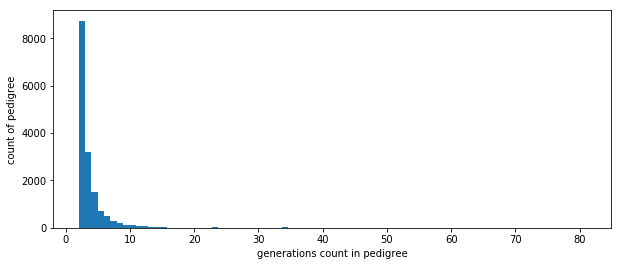

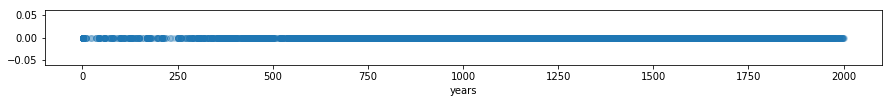

In [8]:
plt.figure(figsize=(10, 4))
plt.hist(generation_counts, bins=80)
plt.xlabel('generations count in pedigree')
plt.ylabel('count of pedigree') # было pedogree
plt.show()

plt.figure(figsize=(15, 1))
plt.scatter(years, np.zeros_like(years), alpha=0.2)
plt.xlabel('years')
plt.show()

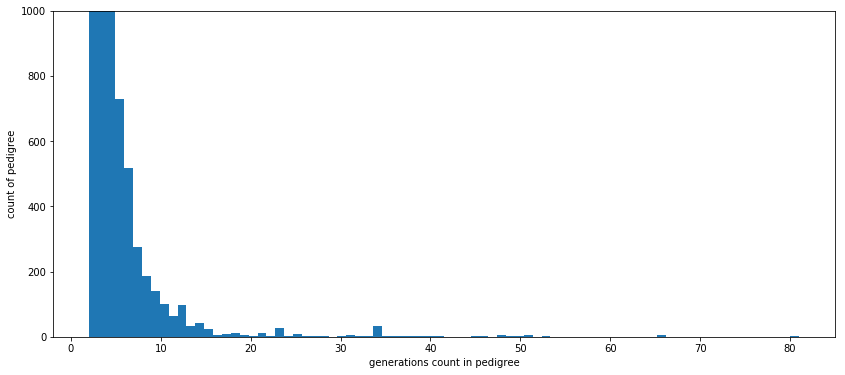

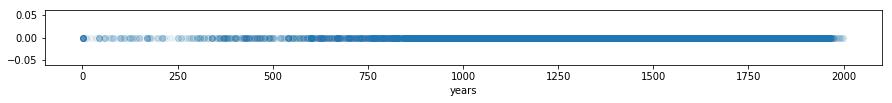

In [9]:
plt.figure(figsize=(14, 6)) # was figsize=(10,4)
plt.ylim(ymax=1000)
plt.hist(generation_counts, bins=80)
plt.xlabel('generations count in pedigree')
plt.ylabel('count of pedigree') # было pedogree

plt.show()

plt.figure(figsize=(15, 1))
plt.scatter(years, np.zeros_like(years), alpha=0.025) # was alpha=0.2
plt.xlabel('years')
plt.show()

Посчитайте среднюю продолжительность жизни.

In [10]:
ages = []
for pedigree in processes:
    for generation in pedigree.generations:
        for person in generation:
            if person.birthday != '' and person.deathdate != '':
                ages.append(int(person.deathdate.split('-')[0]) - \
                            int(person.birthday.split('-')[0]))

### !  В коде выше мы берём разность года рождения и года смерти, 
### ! т.е. продолжительности жизни оценена с ошибкой до года,
### ! хотя среднее должно пострадать не сильно

mean_age = np.mean(ages)
print(round(mean_age, 2))

56.56


## 2. Оценка закона размножения

Для начала предположим, что все выданные вам процессы являются частью одного большого процесса с общим предком. В следующем задании рассмотрим так же случай, когда все процессы являются разными.

Чтобы проводить какой-либо анализ ветвящегося процесса нужно некоторым образом оценить закон размножения. Кажется,  что для этого достаточно посчитать количество сыновей у каждого человека, получив тем самым выборку неотрицательных целых чисел. Однако, проблема в том, что данные неполные, в частности, некоторые поля могут быть не заполнены. Тем не менее обычно у человека указаны либо все дети, либо не указаны вообще. 
Таким образом, условно мы можем разделить выборку на две части: поле детей заполнено (в т.ч. если у человека на самом деле нет детей), поле детей незаполнено. Если бы первая часть выборки была бы полностью известна, что распределение можно оценить по ней. Нам же неизвестен размер выборки и количество нулевых элементов в ней. Количество положительных элементов известно.


**Математическая постановка задачи**

$\mathsf{P}_\theta$ --- неизвестное распределение из некоторого класса распределений $\mathcal{P}$ на $\mathbb{Z}_+$.

$X_1, ..., X_n$ --- выборка из распределения $\mathsf{P}_\theta$, причем $n$ и количество нулей в выборке неизвестны. 

$Y_1, ..., Y_s$ --- положительная подвыборка, которая полностью нам известна. В нашей задаче $Y_j$ --- количество сыновей у $j$-го человека среди тех, у кого есть хотя бы один сын.

Оценку параметра $\theta$ можно найти методом максимального правдоподобия:

$$\prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) \to \max_\theta$$ 

В качестве классов распределений $\mathcal{P}$ рассмотрите пуассоновское и геометрическое распределения. По желанию можете рассмотреть другие классы распределений, осмысленные в данной задаче

**Внимание!** Применение метода `fit` из `scipy.stats` является некорректным в данной задаче, поскольку рассматривается усеченная выборка. Задачу максимизации нужно решить явно, выписав все формулы (которые тоже нужно прислать вместе с кодом).

После оценки параметров проведите проверку принадлежности неизвестного распределения рассматриваемому семейству распределений $\mathcal{P}$ с помощью критерия хи-квадрат, взяв для для него то распределение из $\mathcal{P}$, которое соответствует оценке максимального правдоподобия. Постарайтесь учесть все особенности проверки гипотез, которые обсуждались на семинаре. Для каждого класса постройте также график частот и функции $\mathsf{P}_\theta (y \left| Y > 0 \right).$

____________________

### Оценка ММП

#### 1.Геометрическое распределение

$P_p(X = n) = (1 - p)^n p$ (Геометрическое распределение с нулём, $X \in \{0, 1, 2, ...\}$)

Для положительных $Y_i$ имеем:
$P_p(Y_i | Y_i > 0) = \frac{P(Y_i)}{P(Y_i > 0)} = \frac{P(Y_i)}{1 - P(Y_i = 0)} 
= \frac{(1 - p)^n p}{1 - p} = (1 - p)^{n - 1} p $, т.е. положительные $Y_i$ распределены по геометрическому распределению без нуля.

$$\prod\limits_{i=1}^s P_p(Y_i | Y_i > 0) = \prod\limits_{i=1}^s (1 - p)^{Y_i - 1} p 
= (1-p) ^ {\sum\limits_{i=1}^s{Y_i} - s} p^s $$

$$\Rightarrow (\sum\limits_{i=1}^s{Y_i} - s) \ln{(1-p)} + s \ln{p}$$
Возьмём производную для нахождения точки максимума (из вида логарифмической функции правдоподобия ясно, что при $p \in [0, 1]$ и положительных $Y_i$ (коэффициенты при логарифмах неотрицательны) наблюдается один максимум):

$$ (\sum\limits_{i=1}^s{Y_i} - s) \frac{-1}{1-p} + \frac{s}{p} =: 0 $$
$$ \frac{s}{1-p} - \frac{\sum\limits_{i=1}^s{Y_i}}{1-p} + \frac{s}{p} = 0$$ 
$$ \frac{sp + s - sp}{(1-p)p} = \frac{\sum\limits_{i=1}^s{Y_i}}{1-p}$$ 
$$ p = \frac{s}{\sum\limits_{i=1}^s{Y_i}} = \frac{1}{\overline{Y}}$$

**Итого:** $ p^* = 1/\overline{Y}$ - оценка по ММП для геометрического распределения

#### 2.Пуассоновское распределение

$P_\lambda(X = k) = \frac{\lambda^k}{k!} e^{-\lambda}$; $P_\lambda(X = 0) = e^{-\lambda}$; $P_\lambda(X > 0) = 1 - e^{-\lambda}$

$$\prod\limits_{i=1}^s P_\lambda(Y_i | Y_i > 0)
= \prod\limits_{i=1}^s \frac{\frac{\lambda^{Y_i}}{{Y_i}!} e^{-\lambda}}{1 - e^{-\lambda}}
= \frac{\frac{\lambda^{\sum\limits_{i=1}^s{Y_i}}}{\prod\limits_{i=1}^s {Y_i}!} e^{-\lambda n}}{(1 - e^{-\lambda})^n}$$

$$\Rightarrow L(\lambda, Y) = \sum\limits_{i=1}^s{Y_i} \ln{\lambda} - n \lambda - \ln(\prod\limits_{i=1}^s {Y_i}!) - n \ln(1 - e^{-\lambda})$$

$$\Rightarrow L'(\lambda, Y) = \sum\limits_{i=1}^s{Y_i} \frac{1}{\lambda} - n - n \frac{e^{-\lambda}}{(1 - e^{-\lambda})} 
= \sum\limits_{i=1}^s{Y_i} \frac{1}{\lambda} - \frac{n}{(1 - e^{-\lambda})} =: 0$$
Оценка по ММП достигается в корне:
$$ \overline{Y} = \frac{\lambda}{(1 - e^{-\lambda})}$$

Получена возрастающая на $\lambda \in (0, + \infty)$ функция ($\frac{d}{dx} \frac{x}{(1 - e^{-x})} = \frac{e^x (-x + e^x - 1)}{(e^x - 1)^2} > 0$), при этом $\overline{Y} \geq s \geq 1$, а $\lim\limits_{\lambda \rightarrow +0} (\frac{\lambda}{(1 - e^{-\lambda})}) = 1$ (по Тейлору), значит у этого уравнения есть корень, при том один. Его можно найти двоичным поиском или поиском по сетке.

**Итого:** Оценка по ММП достигается в корне (он выражается только через страшные функции и его предлагается искать численными методами, благо функция хорошо для этого подходит):
$$ \overline{Y} = \frac{\lambda}{(1 - e^{-\lambda})}$$

_______

### Проверка теоретических выкладок практическим методом (самодеятельность)
Для проверки предлагается взять числа из некоторых геометрического и пуассоновского распределения и вычислить оценку ММП по сгенерированным данным, сравнить её с исходным параметром "на глаз" (разумно было бы провести проверку множество раз с различными параметрами и размерами выборок, проверяя стат. значимость, например, тем же тестом хи-квадрат, но этот раздел не требуется, его просто жалко удалять)

In [11]:
import scipy.stats as sps
import scipy.optimize
import numpy as np # слишком долго листать на верх

In [12]:
X = sps.poisson(mu=777.).rvs(size=1000)
Y = np.array([x for x in X if x > 0])

print(X[:10])
print(Y[:10])

def f(x):
    return x / (1. - np.exp( - x)) - Y.mean()

scipy.optimize.root(f,2.) # найденный x должен ~= mu

[767 818 817 783 787 773 740 796 789 760]
[767 818 817 783 787 773 740 796 789 760]


    fjac: array([[-1.]])
     fun: array([ 0.])
 message: 'The solution converged.'
    nfev: 5
     qtf: array([ 174.659])
       r: array([-1.])
  status: 1
 success: True
       x: array([ 776.659])

______________

p =  0.42885700091157164


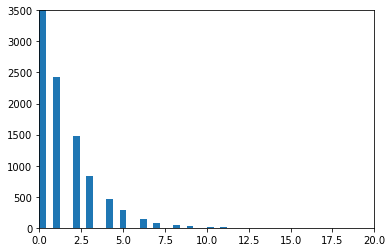

X[:15] = [0 1 0 4 0 0 0 0 0 3 0 1 1 0 4]
Y[:10] = [1 4 3 1 1 4 4 2 1 1]


In [13]:
p = 0.1 + np.random.rand() * 0.8 # ~ U[0.1, 0.9]
print("p = ", p)
X = sps.geom(p=p).rvs(size=10000) - 1
Y = np.array([x for x in X if x > 0])
plt.ylim(ymax=3500)
plt.xlim(xmax=20)
plt.hist(X, bins = 40)
plt.show()
print("X[:15] =", X[:15])
print("Y[:10] =", Y[:10])

In [14]:
theta = 1. / np.array(Y).mean()
print("p = ", p)
print("theta = ", theta) # должны быть приблизительно равны

p =  0.42885700091157164
theta =  0.430306621241


_____________________

### Обработка данных

Составим, для начала Y

In [15]:
male = set()

Y_names = list()
for pedigree in processes:
    for generation in pedigree.generations:
        for person in generation:
            if person.gender == "male":
                male.add(person.name)

# male

In [16]:
Y = list()

for pedigree in processes:
    for generation in pedigree.generations:
        for person in generation:
            if person.gender == "male":
                child_cnt = 0
                for child in person.children:
                    if child in male:
                        child_cnt += 1
                if (child_cnt > 0):
                    Y.append(child_cnt)
print(Y[:10])

[3, 2, 5, 1, 2, 1, 1, 1, 1, 2]


In [17]:
print("len(Y)", len(Y))
Y_data_mean = np.array(Y).mean()

len(Y) 49266


_____
Найдём оценку ММП для пуассоновского распределения:

In [18]:
def poiss_tf(x):
    assert type(Y) == list # вдруг 
    return x / (1. - np.exp(-x)) - Y_data_mean
result = scipy.optimize.root(poiss_tf, 20.)
result

    fjac: array([[-1.]])
     fun: array([  8.88178420e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([ -1.01263575e-09])
       r: array([-0.77214533])
  status: 1
 success: True
       x: array([ 1.80957111])

In [19]:
mu_data = result.x[0]
mu_data

1.8095711098638814

_____
Найдём оценку ММП для геометрического распределения:

In [20]:
p_data = 1. / Y_data_mean
p_data

0.46214025740122316

___________

In [21]:
from scipy.stats import chisquare
print(len(Y))

49266


Применим тест хи-квадрат для полученных данных. Как обсуждалось на семинаре, большой размер выборки нежелателен, в силу ряда причин. Предложено было использовать выборки по сто элементов, что мы и сделаем.

In [22]:
from math import factorial

In [77]:
sub_Y = np.array(np.array(Y)[sps.randint.rvs(0, len(Y), size=100)])


def to_freq_table(sub_Y, ddof=1):
    Y_table = np.zeros(np.array(sub_Y).max() + 1)
    for y in sub_Y:
        Y_table[y] += 1

    
    YY = []
    for i in range(ddof, len(Y_table)):
        if (Y_table[i] < 5):
            YY = Y_table[ddof:i]
            YY[-1] += Y_table[i:].sum()
            break
    return YY

def sum_up(sub_Y, ddof=1):
    Y_table = np.zeros(np.array(sub_Y).max() + 1)
    for y in sub_Y:
        Y_table[y] += 1
    return Y_table[ddof:]

def round_up_five(Y):
    for i in range(len(Y)):
        if Y[i] < 5.:
            if (np.array(Y[i:]).sum() >= 5.):
                YY = Y[:]
                YY[i] = np.array(Y[i:]).sum()
                return YY[:(i+1)]
            else:
                YY = Y[:]
                YY[i-1] += np.array(Y[i:]).sum()
                return YY[:i]
    return Y

def round_up(Y, l):
    assert len(Y) >= l
    YY_temp = np.array(Y)
    YY_temp[l-1] += np.array(YY_temp[l:]).sum()
    return YY_temp[:l]

YY = sum_up(sub_Y)

print("Количество отцов с (i+1) детьми = ", YY)

#print("Количество отцов с (i+1) детьми, с увеличенными группами = ", round_up_five(YY))

# p_data = 1. / sub_Y.mean()

Количество отцов с (i+1) детьми =  [ 56.  20.  11.   6.   6.   1.]


In [78]:
geom = []
pois = []

def geom_cond_pmf(x,p):
    q = 1. - p
    return q ** (x - 1) * p


def pois_cond_pmf(x,mu):
    e = np.exp(- mu)
    return mu ** x * e / (1. - e) / (factorial(x))

i = 1
while (geom_cond_pmf(x=i, p=p_data)*YY.sum() >= 5.):
    geom.append(geom_cond_pmf(x=i, p=p_data))
    i += 1
    
    
i = 1
while (pois_cond_pmf(x=i, mu=mu_data)*YY.sum() >= 5.):
    pois.append(pois_cond_pmf(x=i, mu=mu_data))
    i += 1
    
geom.append(1. - np.array(geom).sum())
if (geom[-1]*YY.sum() < 5.):
    geom[-2] += geom[-1]
    del geom[-1]
    
pois.append(1. - np.array(pois).sum())
if (pois[-1]*YY.sum() < 5.):
    pois[-2] += pois[-1]
    del pois[-1]
    
    
geom = np.array(geom) * YY.sum()
pois = np.array(pois) * YY.sum()
print("YY (данные выборки для теста) = ", YY)
print("YY (укрупнённые для геометрического распределения) = ", round_up(YY, len(geom)))
print("YY (укрупнённые для пуассоновского распределения) = ", round_up(YY, len(pois)))

print("geom (теоретическая выборка из геометрического) = ", geom)
print("pois (теоретическая выборка из пуассоновского) = ", pois)

print(round_up(YY, len(geom)))
print("\nТест для геометрического:\n", sps.chisquare(round_up(YY, len(geom)), geom))
print("\nТест для пуассоновского:\n", sps.chisquare(round_up(YY, len(pois)), pois))

YY (данные выборки для теста) =  [ 56.  20.  11.   6.   6.   1.]
YY (укрупнённые для геометрического распределения) =  [ 56.  20.  11.   6.   7.]
YY (укрупнённые для пуассоновского распределения) =  [ 56.  20.  11.  13.]
geom (теоретическая выборка из геометрического) =  [ 46.21402574  24.85666399  13.3693989    7.19086145   8.36904993]
pois (теоретическая выборка из пуассоновского) =  [ 35.42741384  32.05421229  19.33479217  13.1835817 ]
[ 56.  20.  11.   6.   7.]

Тест для геометрического:
 Power_divergenceResult(statistic=3.8622303239317479, pvalue=0.42497190845565191)

Тест для пуассоновского:
 Power_divergenceResult(statistic=20.0750035809636, pvalue=0.00016377416547257043)


In [25]:
# вычисленная руками для самопроверки статистика 
((round_up(YY, len(geom)) - geom) ** 2 / geom).sum()

16.451208431732606

** Итого: ** при уровне значимости $\alpha = 0.05$ (он определён заранее, хотя впервые фигурирует здесь) 

- в первом тесте нулевая гипотеза, состоящая в том, что законом размножения является геометрическое распределение с оценённым выше параметром (на самом деле, некоторое его угрубление), не может быть отвергнута (pvalue > $\alpha$)

- во втором тесте нулевая гипотеза, состоящая в том, что законом размножения является пуассоновское распределение с оценённым выше параметром (на самом деле, некоторое его угрубление), должно быть от вергнуто (pvalue < $\alpha$)

________________________
### Графики:

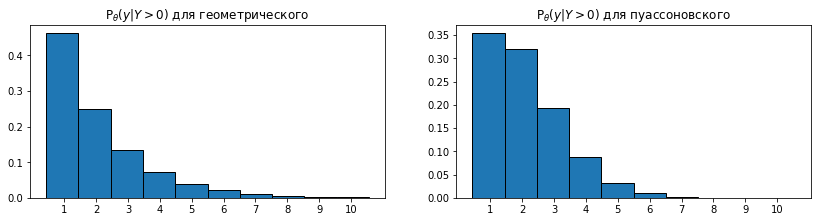

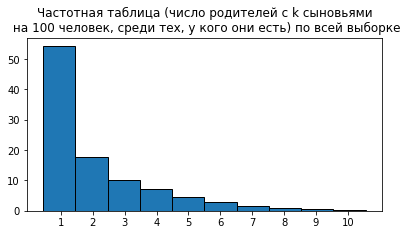

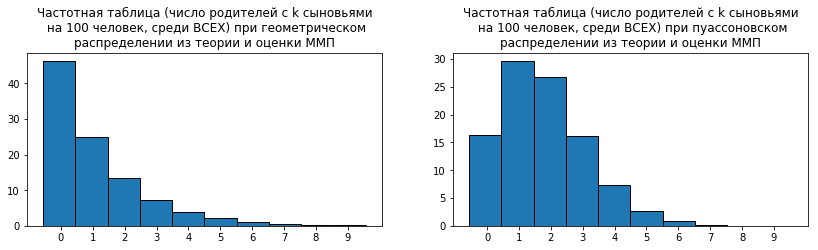

!!! Данные для теста хи-квадрат: !!!


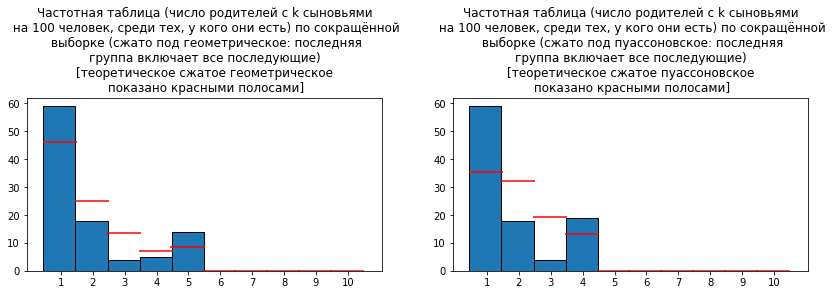

Те же графики наоборот:


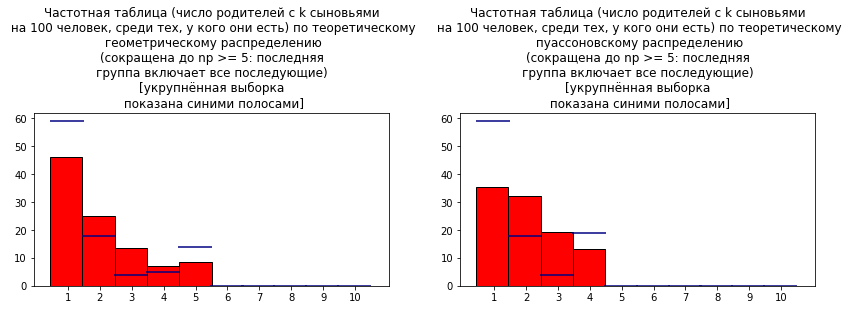

In [26]:
P_geom = [geom_cond_pmf(x,p_data) for x in range(1, 11)]
P_pois = [pois_cond_pmf(x,mu_data) for x in range(1, 11)]

plt.figure(figsize=(14,7))

plt.subplot(221)
plt.hist(range(10), weights=P_geom, ls='solid', ec='black')
plt.title("$\\mathsf{P}_\\theta (y \\left| Y > 0 \\right)$ для геометрического")
plt.xticks(np.linspace(0.5, 8.5, 10), range(1, 11))

plt.subplot(222)
plt.hist(range(10), weights=P_pois, ls='solid', ec='black')
plt.title("$\\mathsf{P}_\\theta (y \\left| Y > 0 \\right)$ для пуассоновского")
plt.xticks(np.linspace(0.5, 8.5, 10), range(1, 11))


def top_ten(X):
    X = list(X)
    while (len(X) < 10):
        X.append(0)
    return np.array(X[:10])

plt.show()
plt.figure(figsize=(14,7))

plt.subplot(221)
FT = top_ten(to_freq_table(Y))
FT = FT / FT.sum() * 100.
plt.hist(range(10), weights=FT, ls='solid', ec='black')
plt.title("Частотная таблица (число родителей с k сыновьями\n " +
          "на 100 человек, среди тех, у кого они есть) по всей выборке")
plt.xticks(np.linspace(0.5, 8.5, 10), range(1, 11))

plt.show()
plt.figure(figsize=(14,7))


plt.subplot(221)
FT = [sps.geom(p=p_data).pmf(i+1)*100 for i in range(0, 10)]
plt.hist(range(10), weights=FT, ls='solid', ec='black')
plt.title("Частотная таблица (число родителей с k сыновьями\n на" + 
          " 100 человек, среди ВСЕХ) при геометрическом\n" +
          "распределении из теории и оценки ММП")
plt.xticks(np.linspace(0.5, 8.5, 10), range(0, 10))

plt.subplot(222)
FT = [sps.poisson(mu=mu_data).pmf(i)*100 for i in range(0, 10)]
plt.hist(range(10), weights=FT, ls='solid', ec='black')
plt.title("Частотная таблица (число родителей с k сыновьями\n на 100 человек, " +
          "среди ВСЕХ) при пуассоновском\n" +
          "распределении из теории и оценки ММП")
plt.xticks(np.linspace(0.5, 8.5, 10), range(0, 10))

plt.show()

print("!!! Данные для теста хи-квадрат: !!!")

hor_len = 0.95
plt.figure(figsize=(14,7))
plt.subplot(221)
plt.hist(range(10), weights=top_ten(round_up(YY, len(geom))), ls='solid', ec='black')
x_grid = np.linspace(0., 8., 10)
plt.hlines(top_ten(geom), x_grid, x_grid+hor_len, color="red")
plt.title("Частотная таблица (число родителей с k сыновьями\n" + 
          " на 100 человек, среди тех, у кого они есть) по сокращённой\n"
          +" выборке (сжато под геометрическое: последняя\nгруппа включает все последующие)" +
          "\n[теоретическое сжатое геометрическое\n показано красными полосами]")
plt.xticks(np.linspace(0.5, 8.5, 10), range(1, 11))
plt.subplot(222)
plt.hist(range(10), weights=top_ten(round_up(YY, len(pois))), ls='solid', ec='black')
x_grid = np.linspace(0., 8., 10)
plt.hlines(top_ten(pois), x_grid, x_grid+hor_len, color="red")
plt.title("Частотная таблица (число родителей с k сыновьями\n" + 
          " на 100 человек, среди тех, у кого они есть) по сокращённой\n"
          +" выборке (сжато под пуассоновское: последняя\nгруппа включает все последующие)" +
          "\n[теоретическое сжатое пуассоновское\n показано красными полосами]")
plt.xticks(np.linspace(0.5, 8.5, 10), range(1, 11))
plt.show()

print("Те же графики наоборот:")
plt.figure(figsize=(14,7))
plt.subplot(221)
plt.hist(range(10), weights=top_ten(geom), ls='solid', ec='black', color="red")
x_grid = np.linspace(0., 8., 10)
plt.hlines(top_ten(round_up(YY, len(geom))), x_grid, x_grid+hor_len, color="navy")
plt.title("Частотная таблица (число родителей с k сыновьями\n" +
          " на 100 человек, среди тех, у кого они есть) по теоретическому\n"
          +" геометрическому распределению\n(сокращена до np >= 5:" +
          " последняя\nгруппа включает все последующие)" +
          "\n[укрупнённая выборка\n показана синими полосами]")
plt.xticks(np.linspace(0.5, 8.5, 10), range(1, 11))
plt.subplot(222)
plt.hist(range(10), weights=top_ten(pois), ls='solid', ec='black', color="red")
x_grid = np.linspace(0., 8., 10)
plt.hlines(top_ten(round_up(YY, len(pois))), x_grid, x_grid+hor_len, color="navy")
plt.title("Частотная таблица (число родителей с k сыновьями\n" +
          " на 100 человек, среди тех, у кого они есть) по теоретическому\n"
          +" пуассоновскому распределению\n(сокращена до np >= 5:" +
          " последняя\nгруппа включает все последующие)" +
          "\n[укрупнённая выборка\n показана синими полосами]")
plt.xticks(np.linspace(0.5, 8.5, 10), range(1, 11)) 
plt.show()

Комментарий к графикам: видно, что геометрическое распределение приближает лучше, и что условная вероятность подсчитана приблизительно корректно (можно вырезать участок из графика с нулями в детях и растянуть их на относительное изменение числа человек в сумме - получится график для условной вероятности)

_________________________
Построим графики $P_\theta(Y | Y>0)$, численно считая, что это функция от действительного, а не натурального (с нулём) числа, отмечая значения при целочисленном аргументе точками. (ещё один график для красоты, чтоб был)

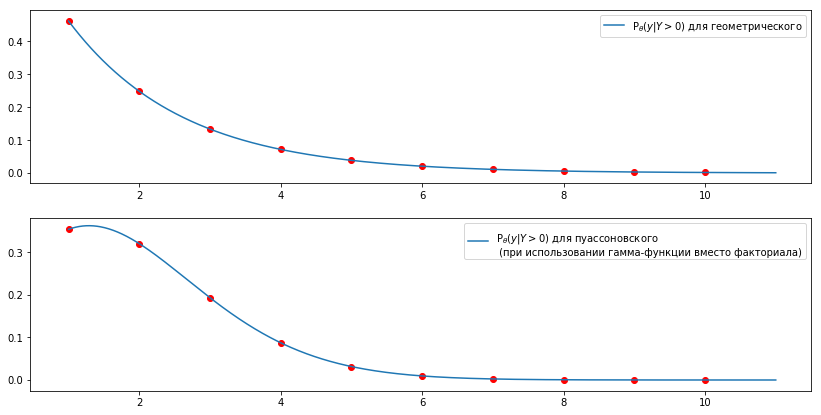

In [27]:
plt.figure(figsize=(14,7))
from math import gamma
def pois_cond_pmf_gamma(x,mu):
    e = np.exp(- mu)
    return mu ** x * e / (1. - e) / (gamma(x+1))


plt.subplot(211)
grid = np.linspace(1, 11, 1000)
n_grid = np.arange(1, 11, 1)

plt.plot(grid, [geom_cond_pmf(x,p_data) for x in grid], label=
         "$\\mathsf{P}_\\theta (y \\left| Y > 0 \\right)$ для геометрического")
plt.scatter(n_grid, [geom_cond_pmf(x,p_data) for x in n_grid], color="red")
plt.legend()
plt.subplot(212)
plt.plot(grid, [pois_cond_pmf_gamma(x,mu_data) for x in grid], label=
         "$\\mathsf{P}_\\theta (y \\left| Y > 0 \\right)$ для пуассоновского\n" +
         " (при использовании гамма-функции вместо факториала)")
plt.scatter(n_grid, [pois_cond_pmf(x,mu_data) for x in n_grid], color="red")
plt.legend()
plt.show()

### Множественное тестирование

In [69]:
def get_pval(Y, size=100, text=False):
    sub_Y = np.array(np.array(Y)[sps.randint.rvs(0, len(Y), size=100)])
    
    p_data = 1. / sub_Y.mean()
    def f(x):
        return x / (1. - np.exp( - x)) - sub_Y.mean()

    mu_data = scipy.optimize.root(f,2.).x[0]

    
    def to_freq_table(sub_Y, ddof=1):
        Y_table = np.zeros(np.array(sub_Y).max() + 1)
        for y in sub_Y:
            Y_table[y] += 1


        YY = []
        for i in range(ddof, len(Y_table)):
            if (Y_table[i] < 5):
                YY = Y_table[ddof:i]
                YY[-1] += Y_table[i:].sum()
                break
        return YY

    def sum_up(sub_Y, ddof=1):
        Y_table = np.zeros(np.array(sub_Y).max() + 1)
        for y in sub_Y:
            Y_table[y] += 1
        return Y_table[ddof:]

    def round_up_five(Y):
        for i in range(len(Y)):
            if Y[i] < 5.:
                if (np.array(Y[i:]).sum() >= 5.):
                    YY = Y[:]
                    YY[i] = np.array(Y[i:]).sum()
                    return YY[:(i+1)]
                else:
                    YY = Y[:]
                    YY[i-1] += np.array(Y[i:]).sum()
                    return YY[:i]
        return Y

    def round_up(Y, l):
        assert len(Y) >= l
        YY_temp = np.array(Y)
        YY_temp[l-1] += np.array(YY_temp[l:]).sum()
        return YY_temp[:l]

    YY = sum_up(sub_Y)

    if (text):
        print("Количество отцов с (i+1) детьми = ", YY)
    #print("Количество отцов с (i+1) детьми, с увеличенными группами = ", round_up_five(YY))
    
    geom = []
    pois = []

    def geom_cond_pmf(x,p):
        q = 1. - p
        return q ** (x - 1) * p


    def pois_cond_pmf(x,mu):
        e = np.exp(- mu)
        return mu ** x * e / (1. - e) / (factorial(x))

    i = 1
    while (geom_cond_pmf(x=i, p=p_data)*YY.sum() >= 5.):
        geom.append(geom_cond_pmf(x=i, p=p_data))
        i += 1


    i = 1
    while (pois_cond_pmf(x=i, mu=mu_data)*YY.sum() >= 5.):
        pois.append(pois_cond_pmf(x=i, mu=mu_data))
        i += 1

    geom.append(1. - np.array(geom).sum())
    if (geom[-1]*YY.sum() < 5.):
        geom[-2] += geom[-1]
        del geom[-1]

    pois.append(1. - np.array(pois).sum())
    if (pois[-1]*YY.sum() < 5.):
        pois[-2] += pois[-1]
        del pois[-1]


    geom = np.array(geom) * YY.sum()
    pois = np.array(pois) * YY.sum()
    if (text):
        print("YY (данные выборки для теста) = ", YY)
        print("YY (укрупнённые для геометрического распределения) = ", round_up(YY, len(geom)))
        print("YY (укрупнённые для пуассоновского распределения) = ", round_up(YY, len(pois)))

        print("geom (теоретическая выборка из геометрического) = ", geom)
        print("pois (теоретическая выборка из пуассоновского) = ", pois)

        print(round_up(YY, len(geom)))
    pval_geom = sps.chisquare(round_up(YY, len(geom)), geom).pvalue
    pval_pois = sps.chisquare(round_up(YY, len(pois)), pois).pvalue
    
    if (text):
        print("\nТест для геометрического:\n", pval_geom)
        print("\nТест для пуассоновского:\n", pval_pois)
    return [pval_geom, pval_pois]

print(get_pval(Y))
pvals = np.array([get_pval(Y) for i in range(8)])
pvals

[0.81589737469117696, 0.00027692790498076058]


array([[  7.13941536e-02,   3.27294101e-08],
       [  1.20700592e-01,   5.96570755e-09],
       [  2.55500869e-01,   7.24007061e-04],
       [  1.47073218e-01,   4.31046922e-07],
       [  4.09874966e-01,   1.00168316e-04],
       [  4.66964371e-01,   3.02156180e-04],
       [  2.73949228e-02,   6.29352211e-09],
       [  6.42735329e-02,   9.29305323e-08]])

In [70]:
pvals_geom = pvals[:, 0]
pvals_pois = pvals[:, 1]

Протестируем на восьми различных выборках гипотезу о том, что распределение - геометрическое.

In [71]:
from statsmodels.sandbox.stats.multicomp import multipletests
multipletests(pvals_geom, alpha=0.05, method='bonferroni')

(array([False, False, False, False, False, False, False, False], dtype=bool),
 array([ 0.57115323,  0.96560473,  1.        ,  1.        ,  1.        ,
         1.        ,  0.21915938,  0.51418826]),
 0.0063911509545450107,
 0.00625)

Теперь протестируем гипотезу о том, что распределение - пуассоновское.

In [72]:
multipletests(pvals_pois, alpha=0.05, method='bonferroni')

(array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool),
 array([  2.61835281e-07,   4.77256604e-08,   5.79205649e-03,
          3.44837538e-06,   8.01346530e-04,   2.41724944e-03,
          5.03481769e-08,   7.43444258e-07]),
 0.0063911509545450107,
 0.00625)

Теперь протестируем 16 гипотез одновременно, первые восемь - за геометрическое, последние восемь - за пуассоновское. При этом (в методе Бонферрони) гипотезы, которые не отвергались будут не отвергаться, но те, что отвергались могут начать не отвергаться. При проверке большого числа гипотез этим методом падает мощность и использование этого метода не рекомендуется.

In [73]:
pvals_all = list(pvals_geom) + list(pvals_pois)
multipletests(pvals_all, alpha=0.05, method='bonferroni')

(array([False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True], dtype=bool),
 array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          4.38318764e-01,   1.00000000e+00,   5.23670561e-07,
          9.54513208e-08,   1.15841130e-02,   6.89675075e-06,
          1.60269306e-03,   4.83449888e-03,   1.00696354e-07,
          1.48688852e-06]),
 0.0032006977101884937,
 0.003125)

**Вывод:** множественное тестирование по варианту, предложенному на семинаре, демонстрирует аналогичный ответ:
- в первом тесте нулевая гипотеза, соответствующая геометрическому распределению **не** отвергается на данном $\alpha$ (все 8 тестов на различных подвыборках не отвергают гипотезу)
- во втором тесте нулевая гипотеза, соответствующая пуассоновскому распределению отвергается на данном $\alpha$
(единогласно отвергнута всеми 8 тестами)
- при одновременной проверке 16 гипотез с поправкой по методу Бонферрони результаты не меняются.

Замечание: число гипотез для множественного тестирования выбрано 8, т.к. метод Бонферрони не рекомендуется использовать при большем числе гипотез из-за потери мощности (сложно отвергнуть неверные гипотезы).

________________________________________

<h1><font color = "red">Ниже идёт Практическое задание 2.</font></h1>

**Часть 1.**
Используя оценку закона размножения, посчитайте вероятность вырождения процесса (ее оценку, если говорить строго). Если эта вероятность равна 1, посчитайте математическое ожидание общего числа частиц в процессе (его оценку, если говорить строго).

Предположим теперь, что каждый род является самостоятельным процессом (а не частью одного большого) и имеет свой закон размножения. Сделайте оценку закона размножения каждого рода геометрическим распределением. Если в роду имеются данные
о менее 10 мужчинах, то в качестве оценки закона размножения возьмите общую оценку закона размножения, полученную ранее (в случае одного большого процесса). Если в роду нет мужчин, то закон размножения должен быть вырожденным: значение 0 принимается с вероятностью 1. Посчитайте вероятность вырождения каждого процесса. Сколько процессов выродится с вероятностью 1? Сколько процессов имеют вероятность
вырождения менее 0.5?

____________________

Оценим вероятность вырождения процесса (считаем данные одним процессом)

$P(\xi = k) = p (1 - p)^k; k \in Z_{+, 0}$

$\varphi_\xi(z) = E z^\xi = \sum\limits_{k=0}^{\infty} z^k P(\xi = k) =  \sum\limits_{k=0}^{\infty} z^k p (1 - p)^k
= \frac{p}{1 - z (1 - p)}$ 

Решим уравнение $\varphi_\xi(z)=z$

$z = \frac{p}{1 - z (1 - p)} \Leftrightarrow z - z^2(1-p) = p \Leftrightarrow z^2 (1-p) - z + p = 0$

Имеем корни: $z_1 = 1, z_0 = \frac{p}{1-p}$; Заметим (вспоним или подсчитаем аналогично подсчёту выше) математическое ожидание $E \xi = \frac{1 - p}{p}$ 

Таким образом, по теореме о вырождении вероятность вырождения равна:

$q = \min(1, \frac{p}{1-p})$

In [822]:
p_data = 1. / np.array(Y).mean()
print("p* = 1 / mean(Y) = ", p_data)

p* = 1 / mean(Y) =  0.462140257401


In [823]:
q_extinction = lambda p : min(p / (1. - p), 1.) if p != 1 else 1.

print("Вероятность вымирания = ", q_extinction(p_data))

Вероятность вымирания =  0.859220761101


Вероятность не равна единице, было бы странно если все аристократы вдруг выродились..
Если бы она была равна, то для вычисления матожидания предлагалось бы вычислить производящую функцию суммарного числа элементов процесса и взять значение её производной в единице.

________________

Оценим теперь параметры каждого процесса в отдельности. Нужно помнить, что мы выкинули плохие записи в первом практикуме. Будем считать, что люди, у которых не указан пол, не могут представлять фамилию.

In [824]:
# Пробный вывод для лучшего понимания происходящего
# str(processes[0])
for generation in processes[2].generations:
    print("___GENERATION__")
    for man in generation:
        print(man)

___GENERATION__
Phares-187	male	1900-Sep-29	1977-Jul-01				Phares-186
___GENERATION__
Phares-186	male			Phares-187			P-597
___GENERATION__
P-597	unknown			Phares-186			


Оценим число родов, в которых в первом поколении число людей не равно одному и в которых этот человек - не мужчина.

In [825]:
for i, house in enumerate(processes):
    sons = []
    if (len(house.generations[0]) != 1):
        print("len(house.generations[0]) != 1 at i = ", i)
    if (house.generations[0][0].gender != "male"):
        print("house.generations[0][0].gender != male", i)

Их НЕТ!

In [826]:
sons_in_family = []

for i, house in enumerate(processes):
    sons = []
    if (len(house.generations[0]) != 1):
        print(i)

    for generation in house.generations:
        for person in generation:
            if person.gender == "male":
                child_cnt = 0
                for child in person.children:
                    if child in male:
                        child_cnt += 1
                if (child_cnt > 0):
                    sons.append(child_cnt)
    sons_in_family.append(sons)

assert len(sons_in_family) == len(processes)
sons_in_family = np.array(sons_in_family)
sons_in_family[:7]
# pedigrees

array([[3, 2, 5, 1, 2, 1], [1, 1, 1, 2, 1], [1], [1], [1], [], []], dtype=object)

In [827]:
def evaluate_p_for_family(sons):
    t = np.array(sons)
    if (len(t) == 0):  ### ?
        return 1.
    elif (len(t) < 10): 
        # в обсуждении требовалось учитывать именно количество
        # мужчин, о сыновьях которых известно
        return p_data
    else:
        return 1. / t.mean()
    
p_for_family = list(map(evaluate_p_for_family, sons_in_family))
print("p_for_family[:30] = ", p_for_family[:30])
    

p_for_family[:30] =  [0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 1.0, 1.0, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 1.0, 1.0, 1.0, 0.46214025740122316, 1.0, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.52500000000000002, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316, 0.46214025740122316]


Очень много родов оценено или единицей или средним по массиву значением...

q_ext_for_family[:30] =  [ 0.85922076  0.85922076  0.85922076  0.85922076  0.85922076  1.          1.
  0.85922076  0.85922076  0.85922076  0.85922076  0.85922076  0.85922076
  0.85922076  1.          1.          1.          0.85922076  1.
  0.85922076  0.85922076  0.85922076  1.          0.85922076  0.85922076
  0.85922076  0.85922076  0.85922076  0.85922076  0.85922076]


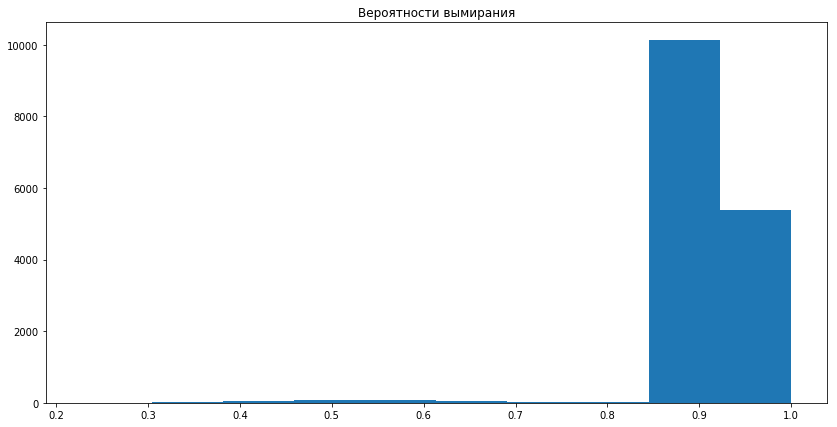

In [831]:
q_ext_for_family = np.array(list(map(q_extinction, p_for_family)))
print("q_ext_for_family[:30] = ", q_ext_for_family[:30])
plt.figure(figsize=(14,7))
plt.hist(q_ext_for_family, bins = 10)
plt.title("Вероятности вымирания")
plt.show()

In [40]:
total = len(q_ext_for_family)
print("Всего процессов", total)
lessthanhalf = q_ext_for_family[q_ext_for_family < 0.5].size
print("Из них вероятность вырождения меньше 0.5 у", lessthanhalf,
      "процессов (", float(lessthanhalf) / total * 100., "%)")
absolutely = q_ext_for_family[q_ext_for_family == 1.0].size
print("Из них выродятся П.Н.", absolutely,
      "процессов (", float(absolutely) / total * 100., "%)")


Всего процессов 15841
Из них вероятность вырождения меньше 0.5 у 129 процессов ( 0.8143425288807524 %)
Из них выродятся П.Н. 5361 процессов ( 33.842560444416385 %)


**Вывод:**    
Наши данные дают очень пессимистичную оценку, т.к. многие люди отсутствуют в базе или их записи настолько неточны, что мы их удалили. Но даже при этом > 65% родов имеют шанс не выродиться.

**Часть 2.**
Вопрос: Как будет меняться численность населения и количество фамилий в течении ближайших 200 лет от текущего момента времени? Помимо оценок требуется построить доверительные интервалы.

Условие данного задания не предполагает какого-либо конкретного алгоритма решения, поэтому вам нужно его придумать самим. Вместе с решением вам нужно прислать достаточно подробное текстовое описание вашего способа решения задачи. В этом описании должны быть пояснения, почему вы выбрали такой метод решения. Оцениваться
будет не только оригинальность решения, но и его логическая или научная обоснованность. Если вы хотите использовать какие-либо модели, о которых вы узнали из дополнительных источников (спецкурсы, онлайн-курсы, книги, научные статьи и т.д.), приведите описание этих моделей.

Идеи решения с обсуждения на семинаре:
1. Моделирование процесса на несколько поколений, то есть генерирование новых
поколений в соответствии с найденным законом размножения. При генерации сто-
ит генерировать только количество потомков, а не самих людей, иначе не хватит
оперативной памяти.
2. Для построения доверительных интервалов можно провести моделирование несколько раз (100-200).
3. Количество поколений, которое нужно сгенерировать, можно определить, оценив
среднее время между поколениями.
4. Для каждого рода количество поколений, которое нужно сгенерировать, может
быть разным в зависимости от времени жизни последнего известного поколения.
5. Длина временного интервала между поколениями может меняться во времени.
Можно попробовать применить регрессию.
6. Закон размножения так же может меняться со временем.

## Изучение данных

Создадим некоторые функции и структуры, которые нам пригодятся в дальнейшем

In [41]:
human_data = dict()  # все данные по имени
for process in processes:
    for generation in process.generations:
        for man in generation:
            human_data[man.name] = man
            
str(human_data["Oak-105"])  # пример

'Oak-105\tunknown\t1912-Nov-04\t1925-Dec-04\tOak-110;Erickson-1125\tOak-106;Oak-100;Oak-99;Oak-97;Oak-94;Oak-84;Oak-101;Oak-90\t\t'

In [42]:
def birthyear(person):  # год рождения по персоне
    if (person.birthday != ""):
        return int(person.birthday[:4]);
    else:
        return np.NaN
    
def deathyear(person):  # год смерти по персоне
    if (person.deathdate != ""):
        return int(person.deathdate[:4]);
    else:
        return np.NaN
    
def lifetime(person):  # время жизни по персоне
    return deathyear(person) - birthyear(person)
    
pp = human_data["Oak-105"]  # пример
birthyear(pp)
deathyear(pp)
print("Oak-105:", lifetime(pp))
print("Murdoch-740:", lifetime(human_data["Murdoch-740"]))

Oak-105: 13
Murdoch-740: nan


**Замечание:** в процессе построения графиков было обнаружено, встретить человека, прожившего больше тысячи лет, (-1000) лет, или одну и ту же персону три раза - норма жизни. (это сильно влияет на среднюю продолжительность жизни, особенно во втором веке)

In [43]:
for i, process in enumerate(processes):
    for generation in process.generations:
        for man in generation:
            if (not np.isnan(lifetime(man))):
                if (lifetime(man) > 300) or (lifetime(man) < -1000):
                    print(i, man)
                    
# Смотрите на даты в выводе! 

369 Este-37	male	1190--	2015--	Este-38;Aldobrandini-1	Este-60;Este-62;Este-61		
1538 Este-37	male	1190--	2015--	Este-38;Aldobrandini-1	Este-60;Este-62;Este-61		
2969 Nabors-259	male	1894-Mar-01	0166-Apr-01	Nabors-248;Gray-13132	Nabors-136;Nabors-267;Nabors-246;Nabors-264;Nabors-262;Nabors-261;Nabors-260;Nabors-266;Nabors-268;Nabors-263		
4830 Champagne-46	female	0100--	1230--	Champagne-135;Capet-107	Blois-132;Ponthieu-7	Avesnes-25;Hohenstaufen-23	Avesnes-68
6931 Ap_Meuric-5	male	1070--	1995--	Ap Jestyn-2			Verch Morgan-5
10343 Taille-3	male	1843-Jun-16	0192-Jan-23				Tailly-1
10347 FitzRandolph-114	female	1787-Jul-16	0184-Apr-05	Fitz Randolph-340;Vance-365	Fitz Randolph-102;Randolph-372;Randolph-518;Fitzrandolph-35;Fitzrandolph-36;FitzRandolph-113;FitzRandolph-112;Randolph-375;FitzRandolph-111		
10349 Taylor-31395	unknown	1854-Jan-17	0185--	Taylor-27693;Kuykendall-726	Taylor-31392;Taylor-31394;Taylor-30046;Taylor-31396;Taylor-31397;Taylor-31398		
10953 Este-37	male	1190--	2015--	Este-3

Будем считать, что больше MAX_LIFETIME = 137 или отрицательное число лет люди не живут и удалим всех, у кого указано иное.

Подсчитаем некоторые параметры для ознакомления

In [44]:
lifetimes = [] 
# здесь лежат кортежи (год рождения,
# продолжительность жизни, число сыновей,
# год рождения среднего сына)

MAX_LIFETIME = 137
for i, process in enumerate(processes):
    for generation in process.generations:
        for man in generation:
            has_son = 0
            son_birthyears = []
            for son in man.children:
                if (son in male):
                    has_son += 1
                    if (not np.isnan(birthyear(human_data[son]))):
                        son_birthyears.append(birthyear(human_data[son]))
                        
            if (len(son_birthyears) > 0):
                ssb = int(np.median(np.array(son_birthyears))) - birthyear(man)
            else:
                ssb = 0
                
            if (not np.isnan(lifetime(man))):
                if (0 <= lifetime(man)) and(lifetime(man) <= MAX_LIFETIME):
                              lifetimes.append((birthyear(man), lifetime(man), has_son, ssb))
                
lifetimes = np.array(lifetimes)
print("lifetimes[:7] = ", lifetimes[:17])
print("Average lifetime (all the years) =", lifetimes[:, 1].mean())
print("Average lifetime (birth after 1900 year) =", lifetimes[lifetimes[:, 0] > 1900, 1].mean())
print("Average lifetime (birth before 1900 year) =", lifetimes[lifetimes[:, 0] < 1900, 1].mean())

lifetimes[:7] =  [[1740   82    3   60]
 [1792   60    2   30]
 [1806   57    0    0]
 [1816   48    5   38]
 [1828   45    0    0]
 [1849   76    1   35]
 [1852   26    0    0]
 [1854   31    2   25]
 [1856   13    0    0]
 [1858   73    1    0]
 [1884   75    0    0]
 [1880   65    0    0]
 [1886   61    0    0]
 [1899   33    0    0]
 [1916   97    0    0]
 [1788   72    1   33]
 [1821   77    1   22]]
Average lifetime (all the years) = 56.8023032777
Average lifetime (birth after 1900 year) = 60.2749785285
Average lifetime (birth before 1900 year) = 56.3869565595


Построим зависимости продолжительности жизни от года и числа людей от года

In [45]:
lifetimes_100_year = np.array(  # продолжительность жизни по векам
    [lifetimes[(i*100 <= lifetimes[:, 0]) & (lifetimes[:, 0] < (i+1)*100), 1].mean()
        for i in range(20)]
)

lifetimes_100_year_size = np.array(   # число людей, по которым составлена статистика выше
    [lifetimes[(i*100 <= lifetimes[:, 0]) & (lifetimes[:, 0] < (i+1)*100), 1].size
         for i in range(20)]
)
print("lifetimes_100_year = ", lifetimes_100_year)
print("lifetimes_100_year_size = ", lifetimes_100_year_size)

lifetimes_100_year =  [ 41.55        55.29411765  49.52631579  63.79207921  57.2         53.4
  46.56198347  59.36271186  53.76145038  52.88709677  51.27677625
  49.56953154  47.40567327  46.51272593  51.56417216  50.99618321
  54.95649862  57.52591109  58.14804225  60.03754312]
lifetimes_100_year_size =  [   20    34    38   101   140   130   242   295   524   992  1886  2711
  2926  2711  2579  3930  9402 27961 58409 14783]


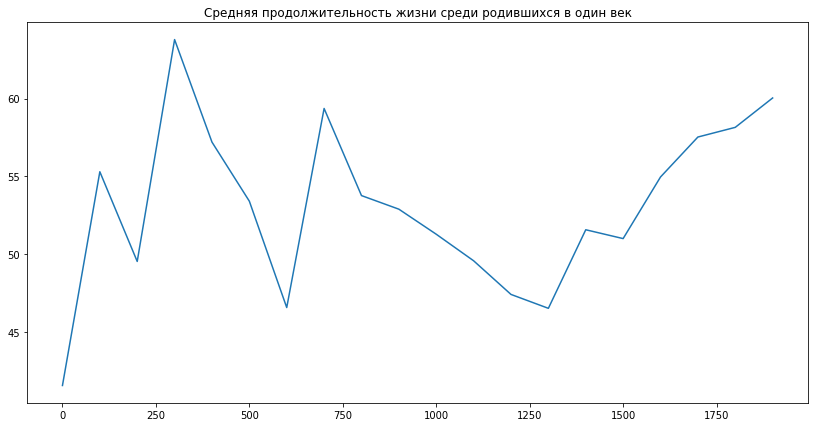

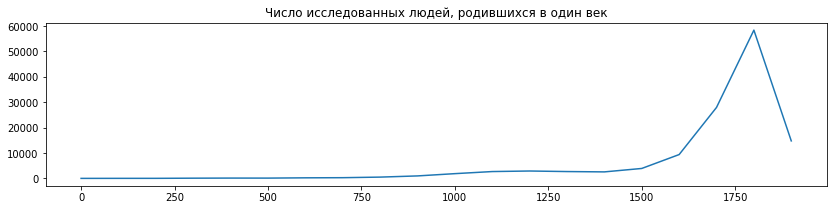

array([ 45,  79,  60,  29,  56, 105, 105,  55,  80,  69,  38,  24,  43,
        71,  30,  45,  79,  60,  29,  56,  50,  45,  79,  60,  29,  56,
        30,  59,  45,  45,  79,  60,  29,  56])

In [46]:
plt.figure(figsize=(14,7))
plt.title("Средняя продолжительность жизни среди родившихся в один век")
plt.plot(np.arange(0, 2000, 100), lifetimes_100_year)
plt.show()

plt.figure(figsize=(14,3))
plt.title("Число исследованных людей, родившихся в один век")
plt.plot(np.arange(0, 2000, 100), lifetimes_100_year_size)
plt.show()

lifetimes[(100 <= lifetimes[:, 0]) & (lifetimes[:, 0] < 200), 1]

На графиках видны результаты эпидемии оспы ("С ХV века Европа уже представляла как бы сплошную оспенную больницу" - https://ru.wikipedia.org/wiki/Натуральная_оспа ) и/или сифилиса (1493 по 1543) (им болели даже папы римские (>=3)).

При этом, есть мнение, что эпидемия чёрной чумы (1346—1353) слабо влияла на аристократию (наверное, в наших данных мало простолюдинов, которые никому не интересны), ибо переносчиками заболевания были крысы и низкий уровень жизни способствовал распространению заболевания, тогда как богатые люди, имея лучшее питание, возможность скрыться в удалённом от городов поместье, и изолированные от основной массы населения, мало болели(в сравнении с другими эпидемиями); эта гипотеза подтверждается нашими данными. 

При этом, начиная с 1300  (или 1500, если выкидывать скачок) года прослеживается рост продолжительности жизни, похожий на линейный, что можно использовать для прогнозирования продолжительности жизни.

Из-за малого количества данных до 1500 года, эпидемий, имевших тогда место, в дальнейшем мы не будем рассматривать годы до 1500.

Однако, по графику видно, что число рождённых в 20 веке также мало (резкий излом), поэтому данные после ~1950 также использованы не будут. Иначе говоря, мы не будем рассматривать рождённых после рубежа веков. При этом, длительности жизни, например, живших в первой половине 20 века мы учтём.

_________
Попробуем спрогнозировать продолжительность жизни, зная, что она окололинейна. Замеры средней продолжительности жизни будем производить с интервалом, равным среднему возрасту рождения среднего ребёнка. (чтобы сравнивать продолжительности жизни на таком промежутке, когда она успела измениться сильнее, чем влияют "сезонные" факторы типа войн.)

In [653]:
step = int(lifetimes[lifetimes[:, 3] != 0, 3].mean())  # возраст рождения среднего ребёнка, средний
lifetimes_data_grid =  range(1500, 1901, step)
lifetimes_data = lifetimes[(lifetimes[:, 0] >= 1500) & (lifetimes[:, 0] < 1900 + step), :]
lifetimes_data = lifetimes_data[:, :2]
lifetimes_mean_data = [lifetimes_data[(lifetimes_data[:, 0] >= year) &
                                      (lifetimes_data[:, 0] < year + step), 1].mean()
                          for year in lifetimes_data_grid]
len(lifetimes_data), lifetimes_mean_data, len(lifetimes_mean_data)

(112973,
 [51.138336347197104,
  52.726200505475987,
  49.609868421052632,
  53.551964196916956,
  55.724932769880908,
  53.878755364806864,
  57.323664402423354,
  57.155524546492451,
  57.644493923369517,
  58.673597574182367,
  56.791136072957791,
  57.607943504431489,
  61.190365431333021],
 13)

Получилось мало значений, но мы всё же проверим остатки на нормальность. Прогнозировать будет с помощью своего класса из прошлого семестра и некоторых функций, обрамляющих его работу 

In [654]:
LR_lifetime =  make_linear_regression_like_polyfit(lifetimes_data_grid, lifetimes_mean_data)
ost = lifetimes_mean_data - predict_linear_regression_like_polyfit(LR_lifetime, lifetimes_data_grid)[:, 0]
ost

array([  2.76243246e-03,   8.43776307e-01,  -3.01940606e+00,
         1.75839430e-01,   1.60195772e+00,  -9.91069971e-01,
         1.70698878e+00,   7.91998642e-01,   5.34117735e-01,
         8.16371101e-01,  -1.81294068e+00,  -1.74298354e+00,
         1.09258811e+00])

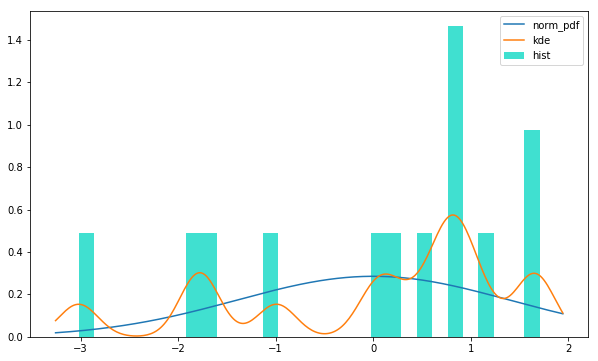

Гипотеза: распределение нормальное.

Статистика критерия Шапиро-Уилка: 0.90178
p-value:  0.14148
Гипотеза не отвергается.

Статистика критерия Колмогорова: 0.1931
p-value:  0.6727
Гипотеза не отвергается.



In [656]:
norm_plot(ost, bins=30, bandwidth=0.2)
check_norm(ost)

Ниже построим график данных и прогноза средней продолжительности жизни.

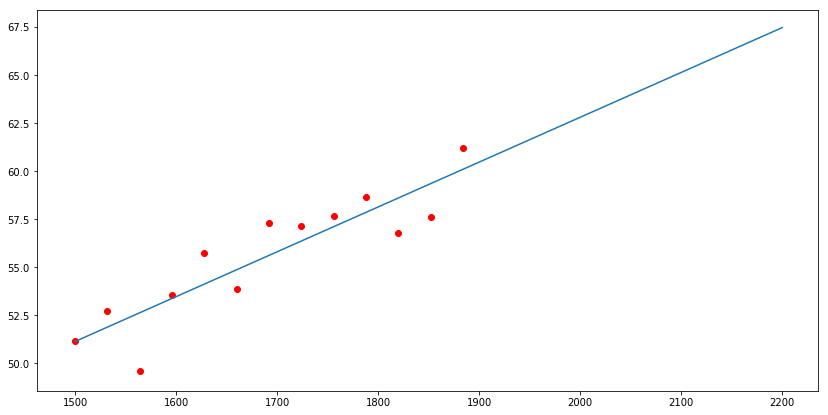

In [663]:
plt.figure(figsize=(14,7))
grid = range(1500, 2201, 10)
plt.plot(grid, predict_linear_regression_like_polyfit(LR_lifetime, grid)[:, 0], label="avg. lifetime prediction")
plt.scatter(lifetimes_data_grid, lifetimes_mean_data, label="avg. lifetime values", color="red")
plt.show()

Новые фамилии (корни процессов) в нашей базе возникают спонтанно, попробуем спрогнозировать, как часто это происходит.

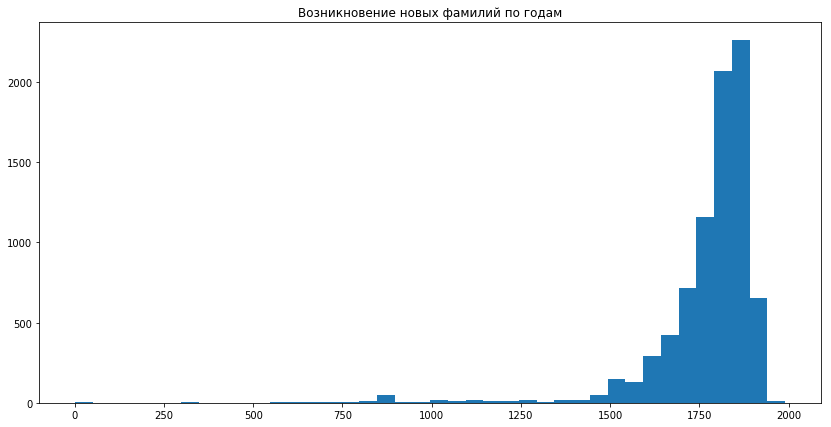

In [665]:
def get_new_families(max_lifetime = 137):
    ans = []
    for process in processes:
        for man in process.generations[0]:
            if (not(np.isnan(birthyear(man)) or np.isnan(deathyear(man)))):
                if (birthyear(man) <= deathyear(man) <= birthyear(man) + max_lifetime):
                    ans.append(birthyear(man))
    ans.sort()
    return np.array(ans)


plt.figure(figsize=(14,7))
plt.title("Возникновение новых фамилий по годам")
plt.hist(get_new_families(), bins=40)
plt.show()

Мне начинает казаться, что в этой задаче все функции - экспоненциальны.

Обратите внимание, что, при том, что в 1800 году население составляет около 15000, из них ~2000 появились из ниоткуда только за последние 20 лет !!! (это без учёта потомком, появившихся из ниоткуда)
<font color="red">
Таким образом, долговременная симуляция ветвящегося процесса, не учитывающая прибытие "с низов общества (появление новых фамилий)", может значимо недооценивать [недооценивала бы при прогнозе с 1800 года, например] прирост популяции. 
</font>

Построим графики.

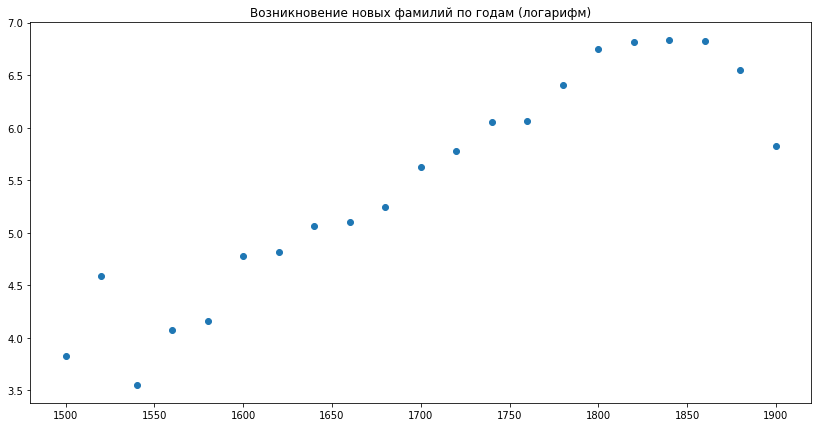

In [666]:
step = 20

lo_year_bound = 1500
hi_year_bound = 1900
new_families = get_new_families()
new_families = new_families[(new_families >= lo_year_bound) & (new_families < hi_year_bound + step)]

res = []

for year in range(lo_year_bound, hi_year_bound + 1, step):
    res.append((year, len(new_families[(year <= new_families) & (new_families < year+step)])))
res = np.array(res)

plt.figure(figsize=(14,7))
plt.title("Возникновение новых фамилий по годам (логарифм)")
plt.scatter(res[:, 0], np.log(res[:, 1]))
plt.show()

Эта функция будет возвращать число рождённых на временном промежутке.

In [667]:
def how_many_was_born(l_year, r_year):
    total = 0
    for process in processes:
        for generation in process.generations:
            for man in generation:
                if (man.gender == "male"):
                    if (birthyear(man) <= deathyear(man) <= birthyear(man) + 137): # MAX_LIFETIME
                        if (l_year <= birthyear(man) < r_year):
                            total += 1
    return total

Гипотеза: отношение возникновения новых фамилий ко всей рождаемости константно (или имеет другую хорошую зависимость)

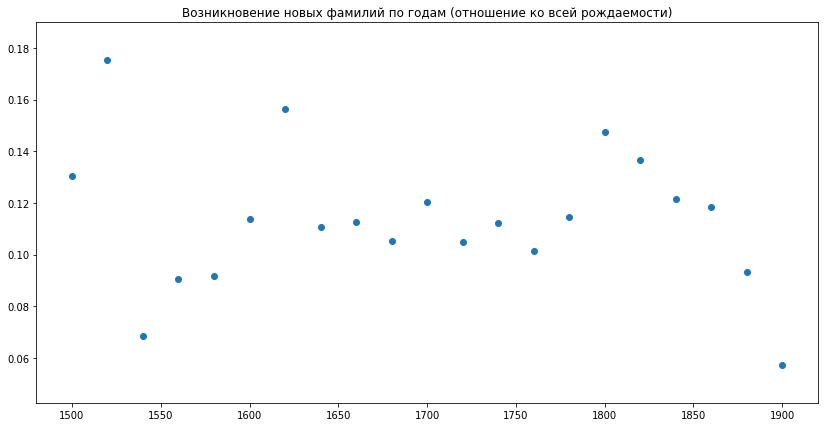

In [736]:
step = 20
lo_year_bound = 1500
hi_year_bound = 1900
new_families = get_new_families()
new_families = new_families[(new_families >= lo_year_bound) & (new_families < hi_year_bound + step)]

res = []
for year in range(lo_year_bound, hi_year_bound + 1, step):
    new_families_added = len(new_families[(year <= new_families) & (new_families < year+step)])
    res.append((year,  new_families_added/how_many_was_born(year, year+step)))
res = np.array(res)
plt.figure(figsize=(14,7))
plt.title("Возникновение новых фамилий по годам (отношение ко всей рождаемости)")
plt.scatter(res[:, 0], res[:, 1])
plt.show()

In [737]:
check_norm(res[:,0])

Гипотеза: распределение нормальное.

Статистика критерия Шапиро-Уилка: 0.95993
p-value:  0.51478
Гипотеза не отвергается.

Статистика критерия Колмогорова: 0.08123
p-value:  0.99908
Гипотеза не отвергается.



Похоже, что это константа "с нормальным шумом", вот оценки его параметров

In [738]:
new_families_koff = res[:,1].mean(), res[:,1].std(ddof=1), step
new_families_koff

(0.11343958894979693, 0.02706905852310524, 20)

Таким образом, для симуляции появления новых фамилий мы можем на каждые 100 спрогнозированных человек добавлять X новых фамилий (так, чтобы X = (X+100) * 0.11343...), ссылаясь на статистику за 1500-1900 года о том, что величина, равная отношению появившихся за 20 лет фамилий к числу всех рождений, распределена нормально со средним в 0.11343... При этом можно попытаться как брать эту константу каждый раз нормального распределения с этими параметрами, так и брать среднее, предположив, что дисперсия имеет место из-за недостаточности данных.

## Метод с симуляцией ветвящегося процесса

Алгоритм симуляции: есть некоторое множество людей, хранящихся в массиве new_arr, как пары (номер фамилии, год рождения).
Мы проходимся по этому массиву, для каждого человека генерируя число его детей из геометрического распределения, оценённого глобально (ибо малое число родов имеет оценку, отличную от среднего по всем родам). После этого, с помощью линейной регрессии, исходя даты рождения генерируется продолжительность жизни, после чего массив old_arr полученных троек  (номер фамилии, год рождения, год смерти) добавляется к результирующему массиву массивов троек generations, а двойки (номер фамилии, год рождения) сгенерированных сыновей (их дата рождения есть сумма даты рождения отца и среднего возраста рождения среднего сына) составляют новое значения массива new_arr. Если какие-то из сыновей родились после границы рассматриваемого периода update, то они повторяются. 

При этом, если число рождённых в некоторое двадцатилетие born_in_period[year/20][0] таково, что было добавлено новых (хранится в born_in_period[year/20][1]) фамилий меньше, чем должно было быть добавлено, то добавляется новая фамилия.

После этого алгоритм запускается столько раз, сколько нужно чтобы все сыновья родились после (up)date. В итоговом массиве хранится информация о каждом жившем человеке в виде (номер фамилии, год рождения, год смерти).

ВНИМАНИЕ: Как и в исходных данных, люди, рождённые в одном массиве new_arr не обязательно жили в пересекющихся временных интервалах! Номер new_arr, в котором были рождены люди определяет только удаление от корня, если он общий (сыновья, внуки, правнуки и т.д.)

ЗАМЕЧАНИЕ: люди хранятся явно, а не как колчества, чтобы эмуляция была более подробной, т.е. небыло скачкообразного рождения людей в поколениях, с одинаковыми датами рождения и смерти. Из минусов такого решения - более медленная работа, но этот выбор был сделан осознанно, благо памяти в системе и терпения на рассчёты (в отличие от времени выполнения этого исследовательского задания) хватает.

In [739]:
mean_child_age = lifetimes[lifetimes[:, 3] != 0, 3].mean() 
# средний возраст, появления среднего сына в семье


avg_lifetime = lifetimes[(1900 <= lifetimes[:, 0]) & (lifetimes[:, 0] < 2000), 1].mean()


def get_child_age(age, sons):
    return mean_child_age

def get_lifetime(age, sons):
    return predict_linear_regression_like_polyfit(LR_lifetime, [age])[0, 0]

def get_new_families_kofficient():  # см. определение new_families_koff
    return new_families_koff

born_in_period = dict()  # здесь хранятся данные о двадцатилетиях
max_family_id = -999

def iteration(arr, log=False):  # одна итерация 
    if log:
        print("Iteration")
    new_arr = []
    old_arr = []
    global born_in_period  # здесь хранятся данные о двадцатилетиях
    global max_family_id
    xis = sps.geom(p=p_data).rvs(size=len(arr)) - 1
    for man_i, man in enumerate(arr):
        family, birth = man
        xi = xis[man_i]
        for i in range(xi):
            bithdate = birth + get_child_age(birth, xi)
            new_arr.append((family, bithdate))
            
            bd_period = int(bithdate) // int(get_new_families_kofficient()[2])
            # двадцатилетка
            
            
            if (log):
                print("Birthday in bd_period = ", bd_period)
            if (not (bd_period in born_in_period.keys())):
                born_in_period[bd_period] = np.array((0, 0))
            born_in_period[bd_period] += np.array([1, 0])
            
            if (born_in_period[bd_period][0] * get_new_families_kofficient()[0]
                    - born_in_period[bd_period][1] >= 0.5): 
                ## new family
                born_in_period[bd_period] += np.array([1, 1])
                max_family_id += 1
                if (log):
                    print("New family", (max_family_id, bithdate))
                new_arr.append((max_family_id, bithdate))
            
        death = birth + get_lifetime(birth, sons)
        old_arr.append((family, birth, death))
    return old_arr, new_arr
        
def iterate(arr, update, log=False):  # все итерации
    global born_in_period  # здесь хранятся данные о двадцатилетиях
    global max_family_id
    
    born_in_period = dict()
    max_family_id = len(arr)
    
    generations = []
    old = None
    new = None
    exit = False
    new = list(arr)[:]
    while (not exit):
        old, new = iteration(new, log=log)
        generations.append(old)
        for i in range(len(new))[::-1]:
            if new[i][1] > update:
                del new[i]
        if (len(new) == 0):
            exit = True
    return generations
        
def slice_new_data(generations, year):
    # даёт данные о численности населения и фамилий
    total = 0
    families = set()
    for generation in generations:
        for man in generation:
            family, birth, death = man
            if ((birth <= year) and (year < death)):
                total += 1
                families.add(family)
    return total, len(families)



def slice_old_data(year):
    # даёт данные о численности населения и фамилий
    total = 0
    families = set()
    for i, process in enumerate(processes):
        for generation in process.generations:
            for man in generation:
                if (man.gender == "male"):
                    if (not np.isnan(birthyear(man))):
                        if (birthyear(man) <= year < deathyear(man)):
                            total += 1
                            families.add(i)
    return total, len(families)

In [743]:
# Sample  
g = iterate([("Stalin", 1900), ("Putin", 1901)], 1970, log=True)
print(slice(g, 1970), g)
print(born_in_period)

Iteration
Birthday in bd_period =  96
Birthday in bd_period =  96
Birthday in bd_period =  96
Birthday in bd_period =  96
Birthday in bd_period =  96
New family (3, 1932.6951585880179)
Birthday in bd_period =  96
Birthday in bd_period =  96
Birthday in bd_period =  96
Iteration
Birthday in bd_period =  98
Birthday in bd_period =  98
Birthday in bd_period =  98
Birthday in bd_period =  98
Birthday in bd_period =  98
New family (4, 1966.3903171760358)
Iteration
Birthday in bd_period =  99
Birthday in bd_period =  99
(15, 4) [[('Stalin', 1900, 1960.471202467457), ('Putin', 1901, 1961.4945415388388)], [('Stalin', 1932.6951585880179, 1993.9294356956002), ('Stalin', 1932.6951585880179, 1993.9294356956002), ('Stalin', 1932.6951585880179, 1993.9294356956002), ('Stalin', 1932.6951585880179, 1993.9294356956002), ('Stalin', 1932.6951585880179, 1993.9294356956002), (3, 1932.6951585880179, 1993.9294356956002), ('Putin', 1933.6951585880179, 1994.952774766982), ('Putin', 1933.6951585880179, 1994.9527

In [744]:
print(p_data)

0.462140257401


Выделим людей, которых мы поместим в первую итерацию - это люди, которые жили в year_split, при том такие, что никто из их отцов не жил в year_split. Таким образом, не будет ситуации, когда для человека с сыновьями в массиве было сгенерировано число сыновей, т.к. если мы добавляет человека, то его сыновей - нет.

In [745]:
data_set = []
year_split = 1900

bfs_layer_old = []
bfs_layer_new = []
for i, process in enumerate(processes):
    for man in process.generations[0]:
        if (man.gender == "male"):
            bfs_layer_new.append((i, man))
while (len(bfs_layer_new) > 0):
    bfs_layer_old = bfs_layer_new
    bfs_layer_new = []
    for (i, man) in bfs_layer_old:
        if (birthyear(man) <= year_split) and (year_split < deathyear(man)):
            data_set.append((i, birthyear(man)))
        else:
            for name in man.children:
                if (name in male):
                    bfs_layer_new.append((i, human_data[name]))
# END BFS

print("data_set[:10] = ", data_set[:10])
len(data_set)

data_set[:10] =  [(2, 1900), (4, 1900), (6, 1855), (7, 1849), (47, 1814), (52, 1852), (66, 1854), (110, 1888), (115, 1865), (121, 1832)]


11174

Число людей, которых мы выбрали

In [746]:
len(data_set)

11174

Смоделируем процесс один раз.

In [747]:
%%time
g = iterate(data_set, 2200)

CPU times: user 31.1 s, sys: 76 ms, total: 31.2 s
Wall time: 31.2 s


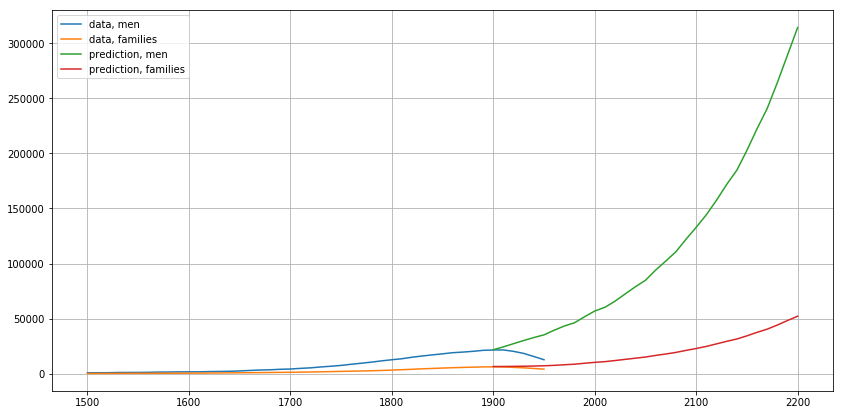

array([20285,  5599])

In [748]:
data_grid = range(1500, 1951, 10)
pred_grid = range(1900, 2201, 10)

data = np.array([slice_old_data(year) for year in data_grid])
pred = np.array([slice_new_data(g, year) for year in pred_grid])

plt.figure(figsize=(14,7))

plt.plot(data_grid, data[:, 0], label="data, men")
plt.plot(data_grid, data[:, 1], label="data, families")

plt.plot(pred_grid, pred[:, 0], label="prediction, men")
plt.plot(pred_grid, pred[:, 1], label="prediction, families")

plt.legend()
plt.grid()

plt.show()
model[0, :]

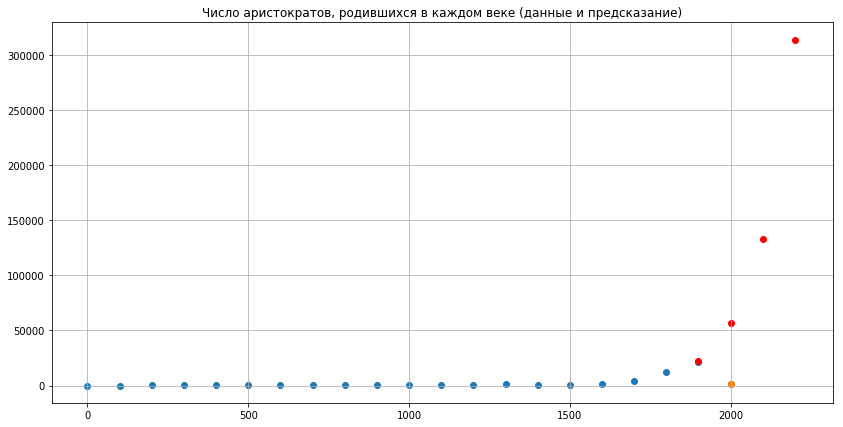

In [749]:
peoples_predict_100 = [slice_new_data(g, year)[0] for year in range(1900, 2210, 100)]
peoples_data_100 = [slice_old_data(year)[0] for year in range(0, 2010, 100)]
                        
plt.figure(figsize=(14,7))
plt.title("Число аристократов, родившихся в каждом веке (данные и предсказание)")
plt.scatter(range(0, 2010, 100), peoples_data_100)
plt.scatter([2000], peoples_data_100[-1])
plt.scatter(range(1900, 2210, 100), peoples_predict_100, color="red")
plt.grid()
plt.show()

Да это же экспонента, закон размножения живых организмов! Жёлтая точка - данные о 20 веке, для того, чтобы ещё раз показать недостаточность данных о людях из этого времени.

________
Построим доверительные интервалы, смоделировав процесс 100 раз и выкинув 5% выбросов. (уровень доверия 95%)

In [750]:
def make_CI(data_set, future_year, years_to_slice, n):
    res = []
    for n_i in range(n):
        print("CI : stage %d of %d" % (n_i+1, n))
        g = iterate(data_set, 2200)
        res.append(tuple(map(lambda year: slice_new_data(g, year), years_to_slice)))
    return np.array(res)

Процесс генерации

In [798]:
%%time
runs = 100
CI_year_grid = range(1900, 2210, 50)
CI = make_CI(data_set, 2200, CI_year_grid, runs)

CI : stage 1 of 100
CI : stage 2 of 100
CI : stage 3 of 100
CI : stage 4 of 100
CI : stage 5 of 100
CI : stage 6 of 100
CI : stage 7 of 100
CI : stage 8 of 100
CI : stage 9 of 100
CI : stage 10 of 100
CI : stage 11 of 100
CI : stage 12 of 100
CI : stage 13 of 100
CI : stage 14 of 100
CI : stage 15 of 100
CI : stage 16 of 100
CI : stage 17 of 100
CI : stage 18 of 100
CI : stage 19 of 100
CI : stage 20 of 100
CI : stage 21 of 100
CI : stage 22 of 100
CI : stage 23 of 100
CI : stage 24 of 100
CI : stage 25 of 100
CI : stage 26 of 100
CI : stage 27 of 100
CI : stage 28 of 100
CI : stage 29 of 100
CI : stage 30 of 100
CI : stage 31 of 100
CI : stage 32 of 100
CI : stage 33 of 100
CI : stage 34 of 100
CI : stage 35 of 100
CI : stage 36 of 100
CI : stage 37 of 100
CI : stage 38 of 100
CI : stage 39 of 100
CI : stage 40 of 100
CI : stage 41 of 100
CI : stage 42 of 100
CI : stage 43 of 100
CI : stage 44 of 100
CI : stage 45 of 100
CI : stage 46 of 100
CI : stage 47 of 100
CI : stage 48 of 100
C

In [799]:
CI_Model_Ready = []
print(CI.shape)
ddof_left = int(runs  * 0.025)
ddof_right = int(runs * 0.025)
for i in range(CI.shape[1]):
    men = CI[:, i, 0]
    men.sort()
    
    fam = CI[:, i, 1]
    fam.sort()
    CI_Model_Ready.append((CI_year_grid[i],
                           men[ddof_left], men[-ddof_right - 1],
                           fam[ddof_left], fam[-ddof_right -1]))
CI_Model_Ready = np.array(CI_Model_Ready)
# CI, CI.min(axis=0), CI.max(axis=0)
CI_Model_Ready

(100, 7, 2)


array([[  1900,  21519,  28783,   6521,   7707],
       [  1950,  34280,  47441,   7019,   9231],
       [  2000,  53488,  72383,   9857,  12950],
       [  2050,  80610, 111376,  14402,  19505],
       [  2100, 125180, 168319,  21619,  28704],
       [  2150, 190094, 262897,  32418,  44296],
       [  2200, 295265, 394796,  49238,  65700]])

Нанесём доверительные интервалы на графики:

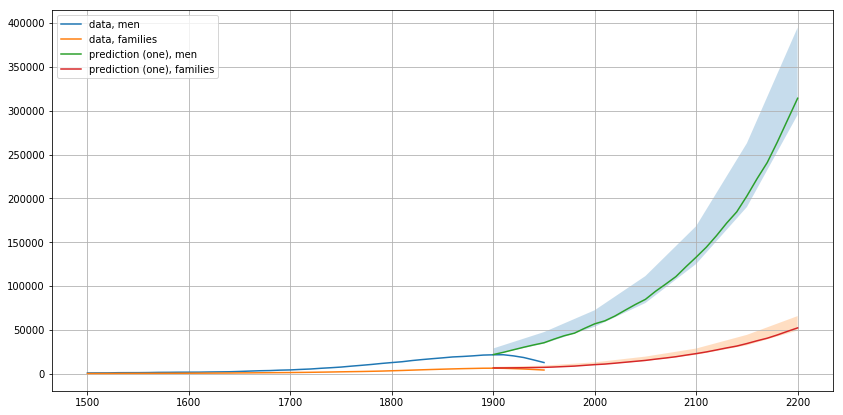

array([20285,  5599])

In [800]:
data_grid = range(1500, 1951, 10)
pred_grid = range(1900, 2201, 10)

data = np.array([slice_old_data(year) for year in data_grid])
pred = np.array([slice_new_data(g, year) for year in pred_grid])

plt.figure(figsize=(14,7))

plt.plot(data_grid, data[:, 0], label="data, men")
plt.plot(data_grid, data[:, 1], label="data, families")

plt.plot(pred_grid, pred[:, 0], label="prediction (one), men")
plt.fill_between(CI_Model_Ready[:, 0], CI_Model_Ready[:, 1], CI_Model_Ready[:, 2], alpha=0.25)

plt.plot(pred_grid, pred[:, 1], label="prediction (one), families")
plt.fill_between(CI_Model_Ready[:, 0], CI_Model_Ready[:, 3], CI_Model_Ready[:, 4], alpha=0.25)

plt.legend(loc=2)
plt.grid()

plt.show()
model[0, :]

## Метод с линейной легрессией

Используем класс для линейной регрессии из прошлого семестра

In [801]:
class LinearRegression:
    def __init__(self):
        super()
        
    def fit(self, X, Y, alpha=0.95):
        ''' Обучение модели. Предполагается модель Y = X * theta + epsilon, 
            где X --- регрессор, Y --- отклик,
            а epsilon имеет нормальное распределение с параметрами N(0, sigma^2 * I_n).
            alpha --- уровень доверия для доверительного интервала.
        '''
        
        self.n, self.k = X.shape

        self.theta = np.linalg.inv(X.T @ X) @ (X.T) @ Y
            # МНК-оценка = (Z.T * Z)^-1 * Z.T * Y

        vector = Y - X @ self.theta
        self.sigma_sq = 1. / (self.n - self.k) * (vector @ vector.T)
            # несмещенная оценка для sigma^2 = 1 / (n - k) * || Y - X * self.theta || ^2 

        a = np.linalg.inv(X.T @ X)
        u_upper = sps.t.ppf((1. + alpha) / 2., self.n - self.k)
        u_lower = sps.t.ppf((1. - alpha) / 2., self.n - self.k)
        ci = [
            [self.theta[i] - np.sqrt(abs(a[i][i] * self.sigma_sq)) * u_upper,
             self.theta[i] - np.sqrt(abs(a[i][i] * self.sigma_sq)) * u_lower]
            for i in range(self.k)
        ]
        self.conf_int = np.array(ci)
        
        return self
    
    def summary(self):
        print('Linear regression on %d features and %d examples' % (self.k, self.n))
        print('Sigma: %.6f' % self.sigma_sq)
        print('\t\tLower\t\tEstimation\tUpper')
        for j in range(self.k):
            print('theta_%d:\t%.6f\t%.6f\t%.6f' % (j, self.conf_int[j, 0], 
                                                   self.theta[j], self.conf_int[j, 1]))
        
    def predict(self, X):
        ''' Возвращает предсказание отклика на новых объектах X. '''
        
        Y_pred = X @ self.theta
        return Y_pred
    
def make_linear_regression_like_polyfit(X, Y):
    LR = LinearRegression()
    LR_X = np.array([np.ones(len(X)), X]).T
    LR.fit(LR_X, np.array(Y).reshape(len(Y), 1))
    return LR

def predict_linear_regression_like_polyfit(LR, X):
    return LR.predict(np.array([np.ones(len(X)), X]).T)

Известно, количество людей растёт по экспоненциальному закону. Было сделано предположение, что это верно и для наших данных. Как оказалось, это похоже на правду на временном промежутке с 1500 года и до 1900 (далее число аристократов падает раза в три, что, скорее всего, объясняется неполными данными (учёт аристократов и их потомков после революций и падений империй затруднён, возможно). Если рассматривать число аристократов за каждые 20 лет, получаем выборку размера 21 элемент, при этом, применяя линейную регрессию, получаем, что остатки распределены нормально (критерий Шапиро-Уилка и Колмогорова из ноутбука с первого семинара не отвергают гипотезу). Будем использовать линейную регрессию для построения прогноза численности , а доверительный интервал строить, как написано в этой (Фёрстер Э., Рёнц Б. Методы корреляционного и регрессионного анализа, ссылка для чтения в браузере: http://edu.alnam.ru/book_mkor.php?id=50 ) на 190ой странице, или здесь (https://studfiles.net/preview/3616903/page:41/ , в учебном пособии Тульского Государственного Университета) 

Времени на персказ доказательства, к сожалению, не осталось.

In [802]:
peoples_data_50 = []
# число мужчин в двадцатилетия, соответствующие датам в date_grid

start_year = 1500
date_grid = range(start_year, 1910, 20)
lr_x = date_grid
for i in date_grid:
    total = 0.
    for process in processes:
        for generation in process.generations:
            for man in generation:
                if (man.gender == "male"):
                    if (not np.isnan(birthyear(man))):
                        if (birthyear(man) <= i < deathyear(man)):
                            total += 1
    peoples_data_50.append(total)

print(peoples_data_50)

[847.0, 929.0, 1176.0, 1295.0, 1559.0, 1715.0, 1952.0, 2215.0, 2986.0, 3583.0, 4304.0, 5360.0, 6817.0, 8603.0, 10549.0, 12700.0, 15006.0, 17125.0, 19104.0, 20356.0, 21558.0]


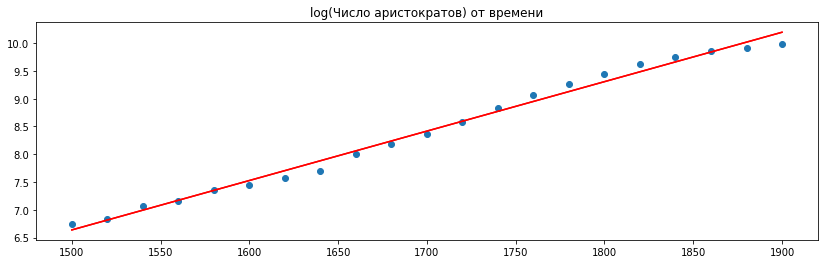

In [803]:
peoples_data_50 = np.array(peoples_data_50)

plt.figure(figsize=(14,4))
plt.title("log(Число аристократов) от времени")
plt.scatter(date_grid, np.log(peoples_data_50))

d = np.polyfit(date_grid, np.log(peoples_data_50), deg=1)
p = np.poly1d(d)
# в качестве альтернативы, можно использовать polyfit, который работает при deg=1 точно так же
# (обратите внимание, что графики совпадают)

def make_linear_regression_like_polyfit(X, Y):
    LR = LinearRegression()
    LR_X = np.array([np.ones(len(X)), X]).T
    LR.fit(LR_X, np.array(Y).reshape(len(Y), 1))
    return LR

def predict_linear_regression_like_polyfit(LR, X):
    return LR.predict(np.array([np.ones(len(X)), X]).T)


#plt.plot(date_grid, list(map(p, date_grid)), color="yellow")

LR_men =  make_linear_regression_like_polyfit(date_grid, np.log(peoples_data_50))
plt.plot(date_grid, predict_linear_regression_like_polyfit(LR_men, date_grid), color="red")

plt.plot(date_grid, predict_linear_regression_like_polyfit(LR_men, date_grid), color="red")
plt.show()


Проверяем остатки на нормальность

In [804]:
ost = np.log(peoples_data_50) - predict_linear_regression_like_polyfit(LR_men, date_grid)[:, 0]
ost, len(ost)

(array([ 0.10412597,  0.01861448,  0.07646034, -0.00506735,  0.00254701,
        -0.08000403, -0.12848216, -0.18000378, -0.05924101, -0.05489481,
        -0.04946996, -0.00797034,  0.05456565,  0.1093376 ,  0.13533816,
         0.14298955,  0.13191814,  0.08608787,  0.01752669, -0.09691487,
        -0.21746314]), 21)

In [805]:
def ret_CI(X, X0, Y0, ost):  # строит доверительный интервал в общем виде
    X = np.array(X)
    n = len(ost)
    sq = 1. + (1./n) + (X0 - X.mean())**2 / ((X-X.mean())**2).sum()
    ost_disp = ost.std(ddof=1)
    length = ost_disp * (sq)**0.5
    tq = sps.t(n-2).ppf(q=0.95)
    return (Y0 - length*tq, Y0 + length*tq)

CI = ret_CI(date_grid, 2200, predict_linear_regression_like_polyfit(LR_men, [2200])[0, 0], ost)
CI=np.array(CI)
np.exp(CI)

array([ 302312.22351111,  494005.12583393])

Построим доверительные интервалы в удобочитаемом виде

In [806]:
CI_Linear_Men_Ready = []
for year in CI_year_grid:
    pred = predict_linear_regression_like_polyfit(LR_men, [year])[0, 0]
    CI_ret = np.exp(np.array(ret_CI(date_grid, year, pred, ost)))
    CI_Linear_Men_Ready.append((year, CI_ret[0], CI_ret[1]))
    
CI_Linear_Men_Ready = np.array(CI_Linear_Men_Ready)
CI_Linear_Men_Ready

array([[   1900.        ,   22038.86863557,   32577.19739139],
       [   1950.        ,   34179.84907468,   51130.52273096],
       [   2000.        ,   52951.17461534,   80338.20662189],
       [   2050.        ,   81950.61155622,  126355.13332407],
       [   2100.        ,  126720.21128016,  198905.39309542],
       [   2150.        ,  195794.41671481,  313357.07278948],
       [   2200.        ,  302312.22351111,  494005.12583393]])

В ячейке ниже - код с первого семинара.

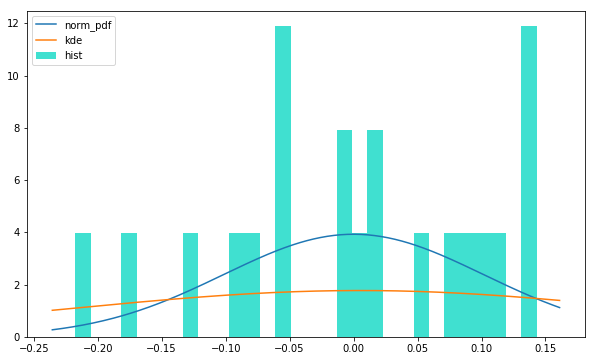

Гипотеза: распределение нормальное.

Статистика критерия Шапиро-Уилка: 0.95607
p-value:  0.44077
Гипотеза не отвергается.

Статистика критерия Колмогорова: 0.10741
p-value:  0.96872
Гипотеза не отвергается.



In [807]:
from sklearn.neighbors import KernelDensity as KDE

def norm_plot(x, bins=10, bandwidth=1):
    plt.figure(figsize=(10, 6))
    plt.hist(x, label="hist", bins=bins, normed=True, color='turquoise')

    xmin, xmax = plt.xlim()
    x_axis = np.linspace(xmin, xmax, 300)

    n_params = sps.norm.fit(x)
    plt.plot(x_axis,
             sps.norm.pdf(x_axis, loc=n_params[0], scale=n_params[1]),
             label="norm_pdf")

    kernel_density = KDE(bandwidth=bandwidth).fit(x[:, np.newaxis])
    plt.plot(x_axis, np.exp(kernel_density.score_samples(x_axis[:, np.newaxis])), label='kde')

    plt.legend()
    plt.show()
    
def check_norm(x, bins=10, alpha=0.05):    
    print("Гипотеза: распределение нормальное.\n")
    
    shtest = sps.shapiro(x)
    print("Статистика критерия Шапиро-Уилка:", round(shtest[0], 5))
    print("p-value: ", round(shtest[1], 5))
    if shtest[1] < alpha:
        print("Гипотеза отвергается.\n")
    else:
        print("Гипотеза не отвергается.\n")

    n_params = sps.norm.fit(x)  # ОМП для нормального распределения
    norm = sps.norm(loc=n_params[0], scale=n_params[1])
    
    kstest = sps.kstest(x, 'norm', args=n_params)
    print("Статистика критерия Колмогорова:", round(kstest.statistic, 5))
    print("p-value: ", round(kstest.pvalue, 5))
    if kstest.pvalue < alpha:
        print("Гипотеза отвергается.\n")
    else:
        print("Гипотеза не отвергается.\n")
    
    # Вспомогательная функция, подсчитывающая число элементов выборки,
    # лежащих в подмножествах разбиения.
    def count_data(x, delim):
        res = []
        res.append((x < delim[0]).sum())
        for i in range(1, len(delim)):
            res.append(((delim[i-1] <= x) & (x < delim[i])).sum())
        res.append((delim[-1] <= x).sum())
        return res
    
    # Критерий хи-квадрат.
    if len(x) < 50:
        return
    
    if 5 > float(len(x)) / bins:
        bins = int(len(x) / 5)
    
    # Разбиение на интервалы, равные по вероятностной мере.
    f_exp = np.ones(bins, dtype=np.float64) / bins
    delim = list(map(lambda y: norm.ppf(y), f_exp.cumsum()))
    delim = delim[:-1]
    ctest = sps.chisquare(count_data(x, delim), f_exp=f_exp * len(x))
    print ("Статистика критерия хи-квадрат при разбиении на интервалы, "\
           "равные по вероятностной мере:",
           round(ctest.statistic, 5))
    print ("p-value: ", round(ctest.pvalue, 5))
    if ctest.pvalue < alpha:
        print ("Гипотеза отвергается.\n")
    else:
        print ("Гипотеза не отвергается.\n")
        
norm_plot(ost, bins=30, bandwidth=0.2)
check_norm(ost)

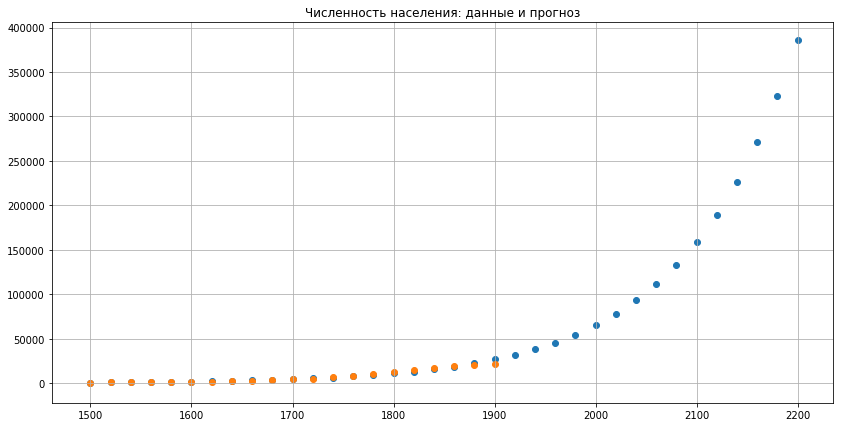

In [808]:
predictions =  np.exp(
    predict_linear_regression_like_polyfit(LR_men, range(1500, 2210, 20))
)

plt.figure(figsize=(14,7))
plt.title("Численность населения: данные и прогноз")
plt.scatter(range(1500, 2210, 20), predictions)
plt.scatter(date_grid, peoples_data_50)
plt.grid()
plt.show()

#### Семьи

Как оказалось, данный метод применим и для числа фамилий. Ниже идёт повторение всех действий, сделанных для количества мужчин в будущем.

In [809]:
def get_families(year):
    res = 0
    for process in processes:
        found = False
        for generation in process.generations:
            for man in generation:
                if (man.gender=="male"):
                    if (birthyear(man) <= year < deathyear(man)):
                        found = True
                        break;
            if (found):
                break;
        if (found):
            res += 1
    return res

year_grid = range(1200, 1950, 20)
families_25 = np.array([get_families(year) for year in year_grid])

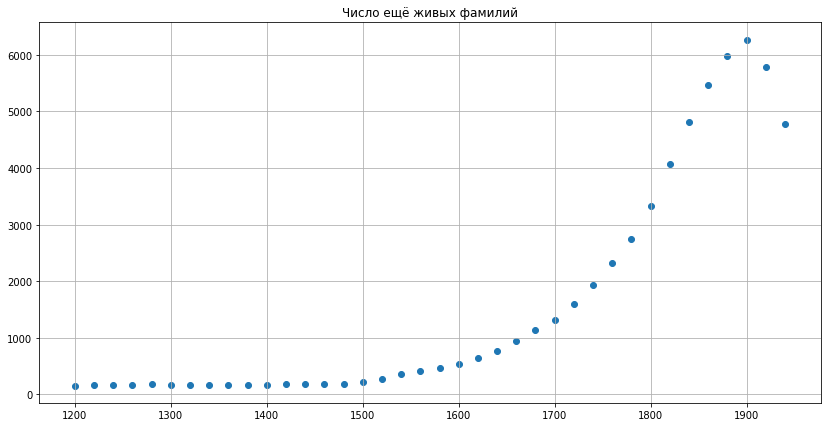

In [810]:
plt.figure(figsize=(14, 7))
plt.title("Число ещё живых фамилий")
plt.scatter(year_grid, families_25)
plt.grid()
plt.show()

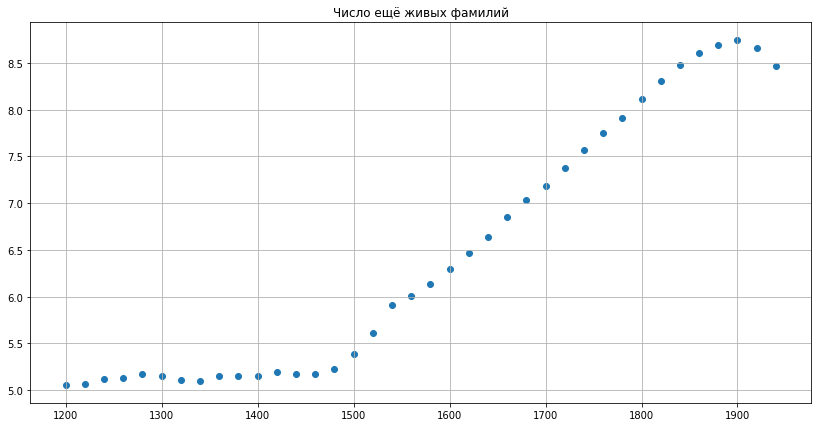

In [811]:
plt.figure(figsize=(14, 7))
plt.title("Число ещё живых фамилий")
plt.scatter(year_grid, np.log(families_25))
plt.grid()
plt.show()

In [812]:
year_grid = range(1500, 1900, 20)
families_20 = np.array([get_families(year) for year in year_grid])
            

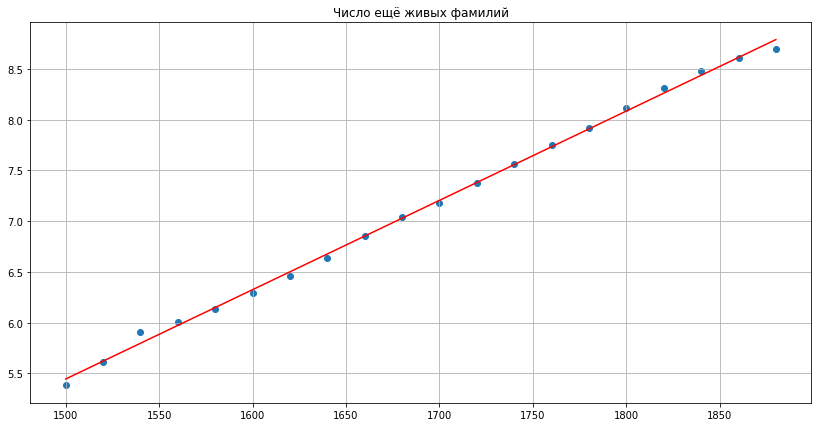

In [813]:
            
plt.figure(figsize=(14, 7))
plt.title("Число ещё живых фамилий")
plt.scatter(year_grid, np.log(families_20))

LR_family =  make_linear_regression_like_polyfit(year_grid, np.log(families_20))
plt.plot(year_grid, predict_linear_regression_like_polyfit(LR_family, year_grid), color ="red")

plt.grid()
plt.show()

In [814]:
ost = np.log(families_20) - predict_linear_regression_like_polyfit(LR_family, year_grid)[:, 0]
ost

array([-0.0564081 , -0.01195764,  0.1134176 ,  0.03055842, -0.0115512 ,
       -0.03180858, -0.03814801, -0.03725124,  0.0033853 ,  0.00887968,
       -0.02262378, -0.00629649,  0.01047057,  0.0182204 ,  0.00730378,
        0.02660408,  0.05146157,  0.04224494, -0.00499055, -0.09151073])

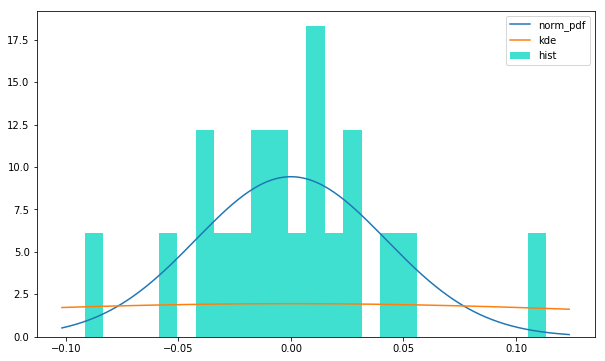

Гипотеза: распределение нормальное.

Статистика критерия Шапиро-Уилка: 0.96801
p-value:  0.71235
Гипотеза не отвергается.

Статистика критерия Колмогорова: 0.10225
p-value:  0.98498
Гипотеза не отвергается.



In [815]:
norm_plot(ost, bins=25, bandwidth=0.2)
check_norm(ost)

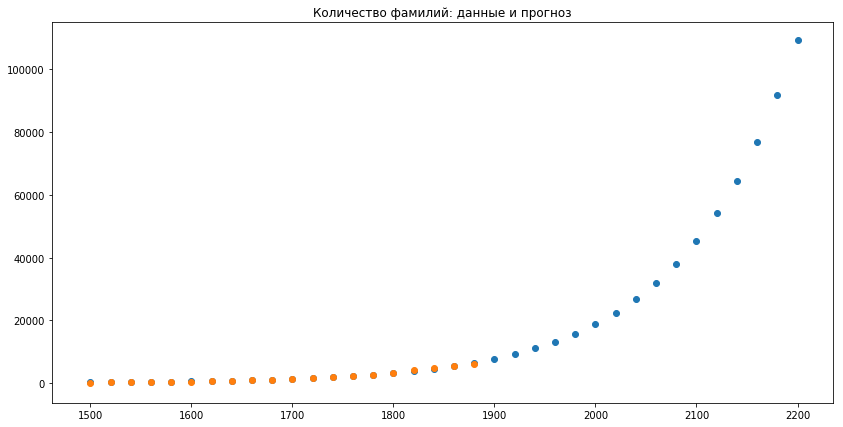

In [816]:

predictions =  np.exp(
    predict_linear_regression_like_polyfit(LR_family, range(1500, 2210, 20))
)

#predictions = [np.exp(p(year)) for year in range(1500, 2210, 20)]
plt.figure(figsize=(14,7))
plt.title("Количество фамилий: данные и прогноз")
plt.scatter(range(1500, 2210, 20), predictions)
plt.scatter(year_grid, families_20)
plt.show()

In [817]:
CI = ret_CI(year_grid, 2200, predict_linear_regression_like_polyfit(LR_family, [2200])[0, 0], ost)
CI = np.array(CI)
np.exp(CI)

array([  98375.59519171,  121891.19389933])

In [818]:
CI_Linear_Family_Ready = []
for year in CI_year_grid:
    pred = predict_linear_regression_like_polyfit(LR_family, [year])[0, 0]
    CI_ret = np.exp(np.array(ret_CI(date_grid, year, pred, ost)))
    CI_Linear_Family_Ready.append((year, CI_ret[0], CI_ret[1]))
    
CI_Linear_Family_Ready = np.array(CI_Linear_Family_Ready)
CI_Linear_Family_Ready

array([[   1900.        ,    7206.40680808,    8486.38312609],
       [   1950.        ,   11160.17699297,   13208.09070677],
       [   2000.        ,   17275.26943843,   20566.29263969],
       [   2050.        ,   26730.02824074,   32036.94819624],
       [   2100.        ,   41344.14448577,   49923.64227457],
       [   2150.        ,   63927.36620522,   77822.14125474],
       [   2200.        ,   98817.67430198,  121345.89113918]])

Построим все доверительные интервалы на одном графике:

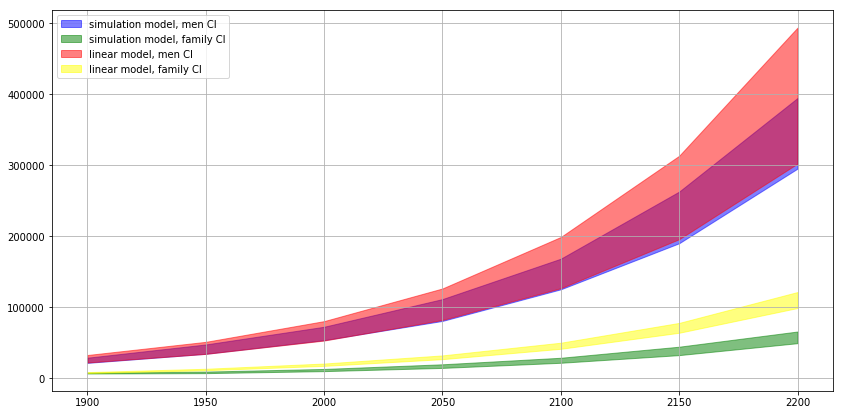

In [819]:
plt.figure(figsize=(14, 7))
plt.fill_between(CI_Model_Ready[:, 0], CI_Model_Ready[:, 1],
                 CI_Model_Ready[:, 2], alpha=0.5,
                 label = "simulation model, men CI", color="blue")
plt.fill_between(CI_Model_Ready[:, 0], CI_Model_Ready[:, 3],
                 CI_Model_Ready[:, 4], alpha=0.5,
                 label = "simulation model, family CI", color="green")

plt.fill_between(CI_Linear_Men_Ready[:, 0], CI_Linear_Men_Ready[:, 1],
                 CI_Linear_Men_Ready[:, 2], alpha=0.5,
                 label = "linear model, men CI", color="red")
plt.fill_between(CI_Linear_Family_Ready[:, 0], CI_Linear_Family_Ready[:, 1],
                 CI_Linear_Family_Ready[:, 2], alpha=0.5,
                 label = "linear model, family CI", color="yellow")
plt.grid()
plt.legend(loc=2)
plt.show()

**Вывод:** Были смоделированы количества мужчин (женщин мы условились не учитывать нигде в пределая данной задачи, посколько роды представляют мужчины) до 2200 года при помощи моделирования ветвящегося процесса и с помощью линейной регрессии, а так же сделаны дополнительные выводы.

Видно, что доверительные интервалы числа людей пересекаются и почти вложены, тогда как для числа фамилий, возможно, имеет место недооценка числа фамилий, появляющихся "из ниоткуда"